# Library Imports

In [2]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
import os
#os.getcwd()
os.chdir('/Users/saiabhiram/Documents/UNCC/Class/Fall 2024/Model Risk Management/Project')
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message='l1_ratio parameter is only used when penalty is.*')


In [3]:
os.getcwd()
#os.chdir('/Users/Grant/Documents/Model Risk Mgmt/MRM-Project')

'/Users/saiabhiram/Documents/UNCC/Class/Fall 2024/Model Risk Management/Project'

## We followed the Starter_Notebook steps so that preprocessing was not included here

In [4]:
loan_df = pd.read_pickle('clean_df_for_eda.pkl')

In [5]:
# Subsetting data to 200k rows
subset_size = 200000

# Calculate the sample size for each category in the target column
proportions = loan_df['fully_paid'].value_counts(normalize=True)
sample_sizes = (proportions * subset_size).round().astype(int)

# Perform stratified sampling on the target column
loan_df = (
    loan_df.groupby('fully_paid', group_keys=False)
    .apply(lambda group: group.sample(n=sample_sizes[group.name], random_state=42))
)

In [6]:
num_cols = loan_df.select_dtypes(include=['float64'])

## Outlier detection and removal. Using z-scores to handle outlier removal

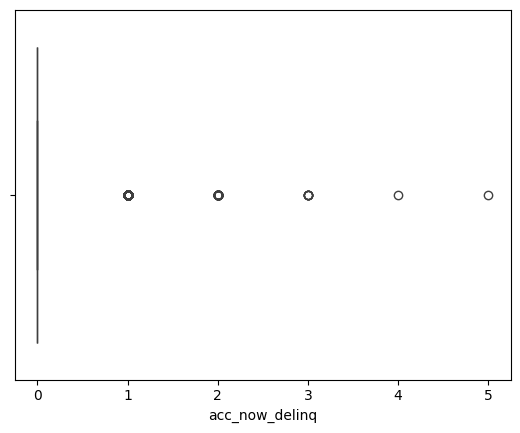

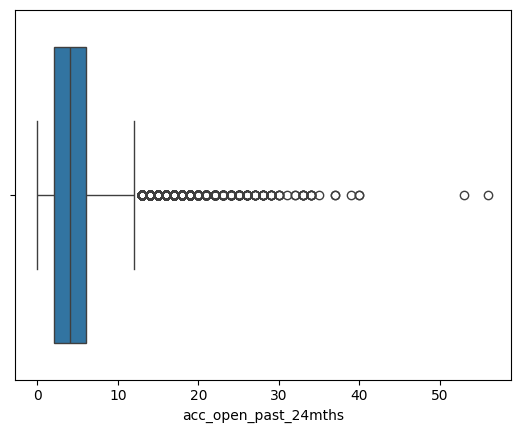

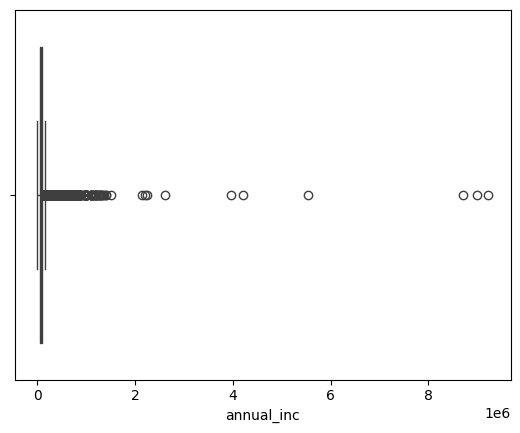

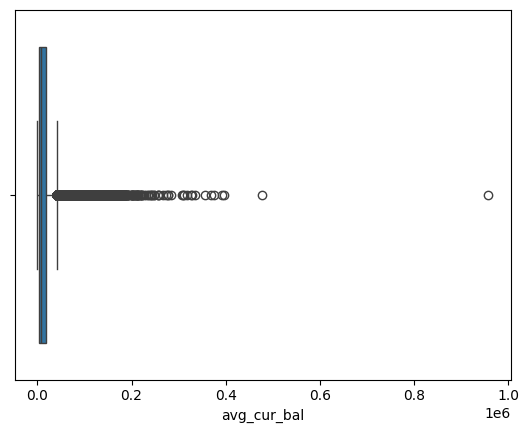

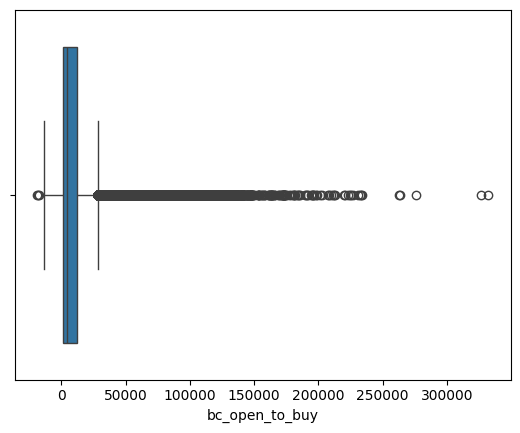

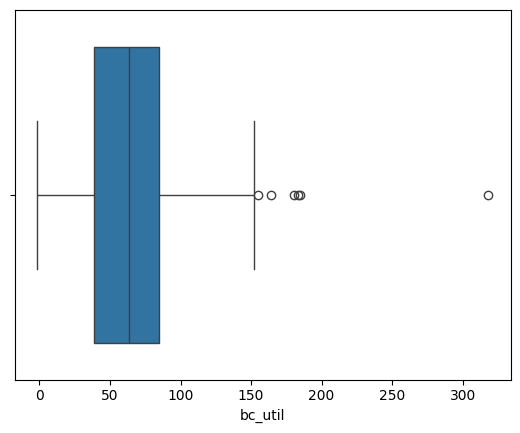

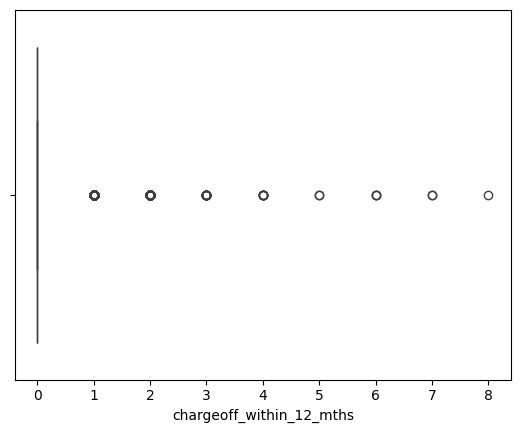

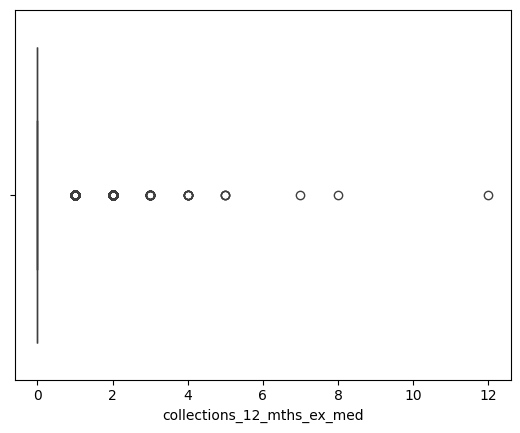

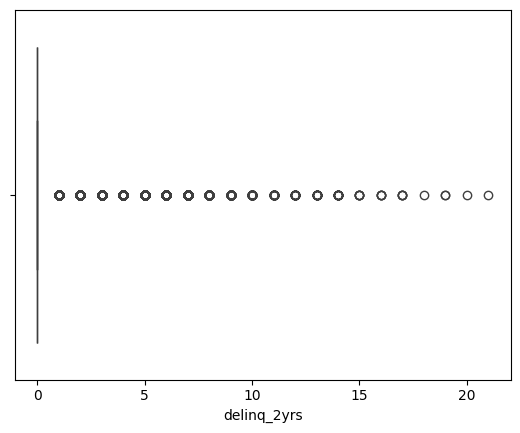

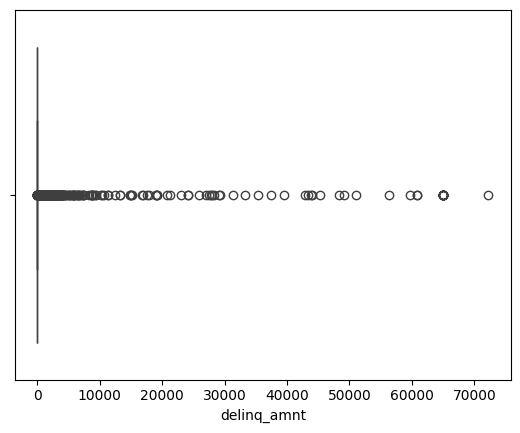

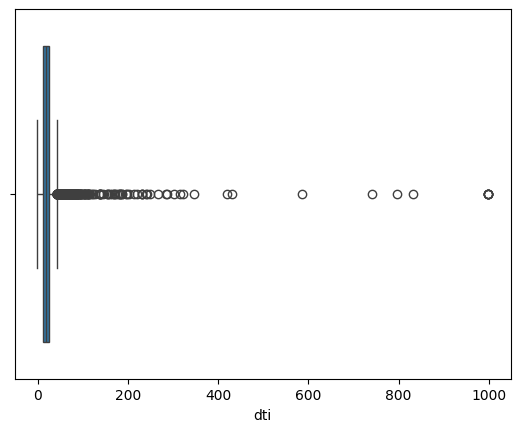

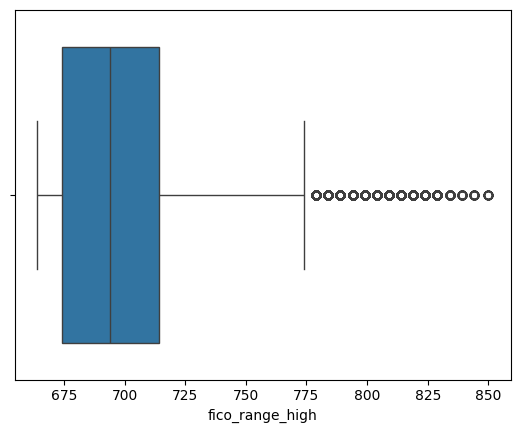

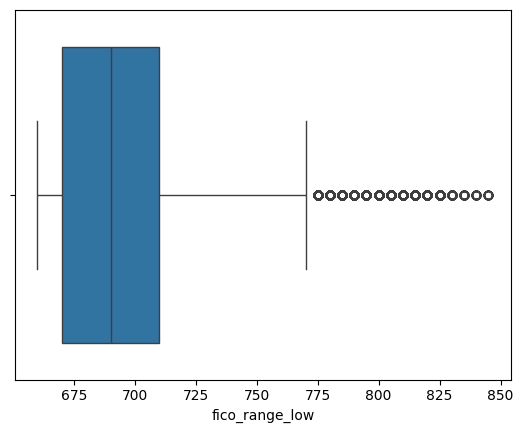

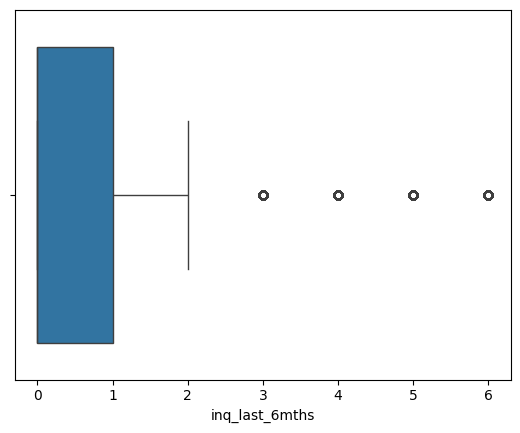

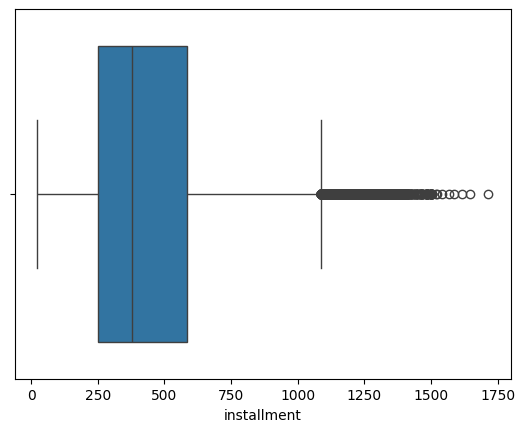

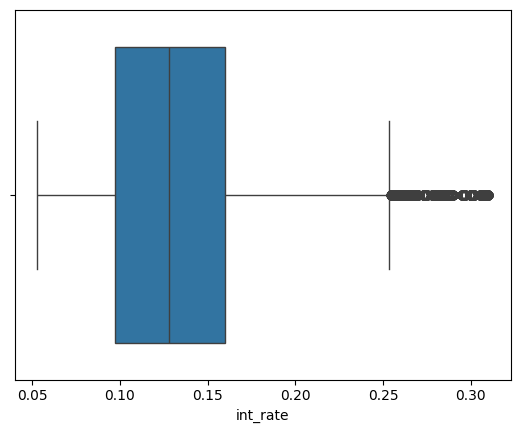

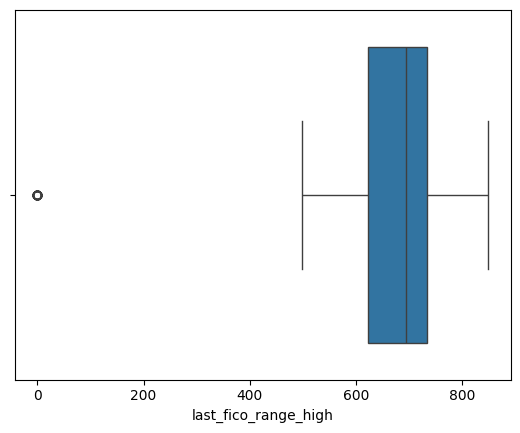

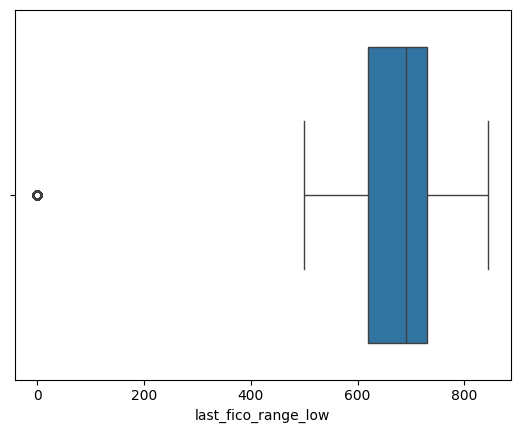

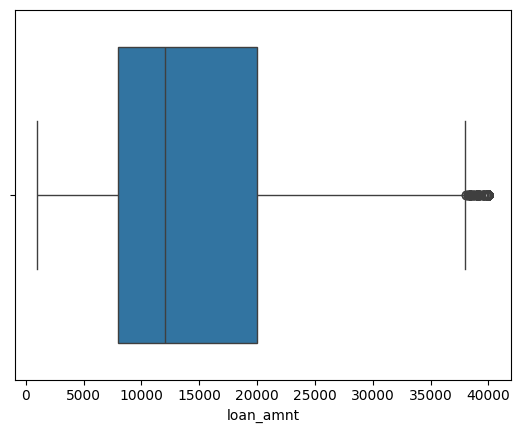

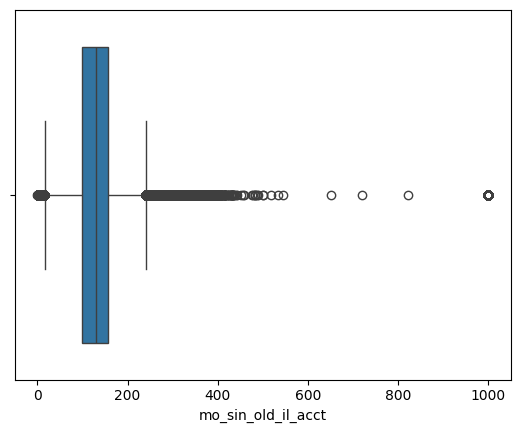

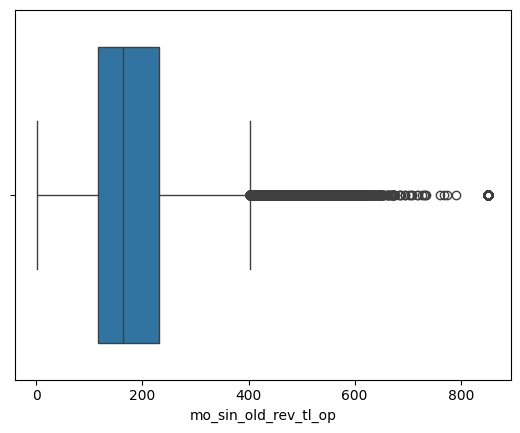

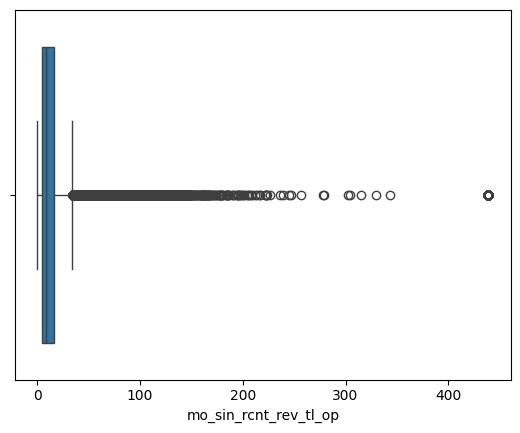

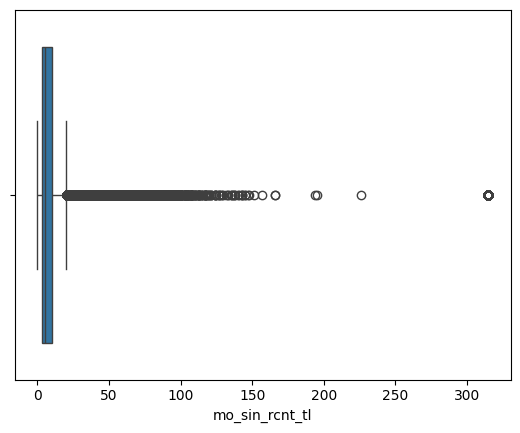

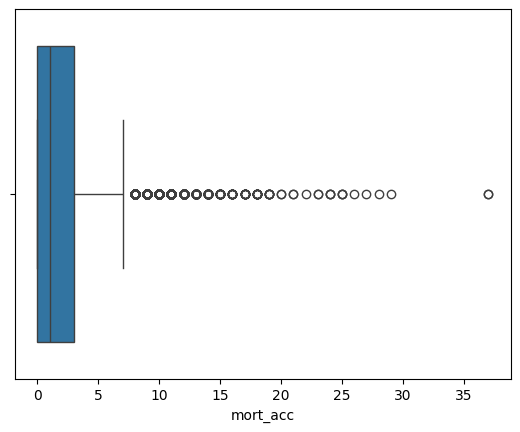

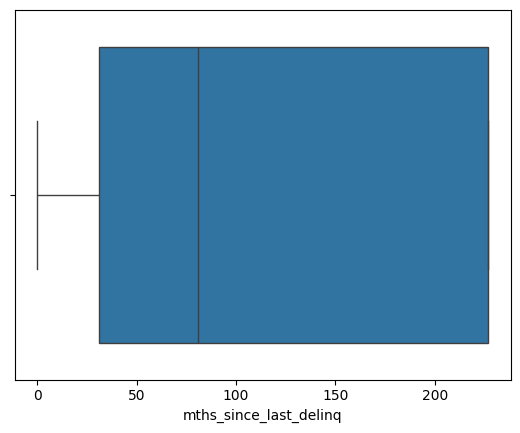

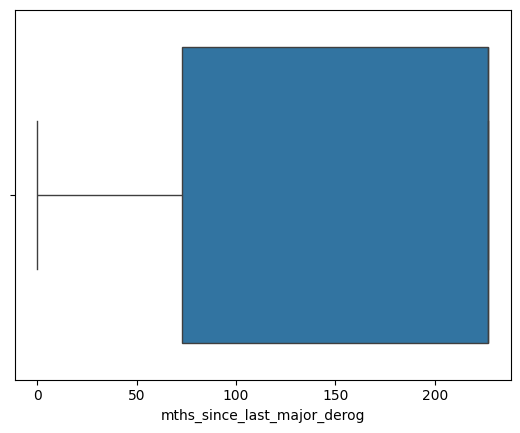

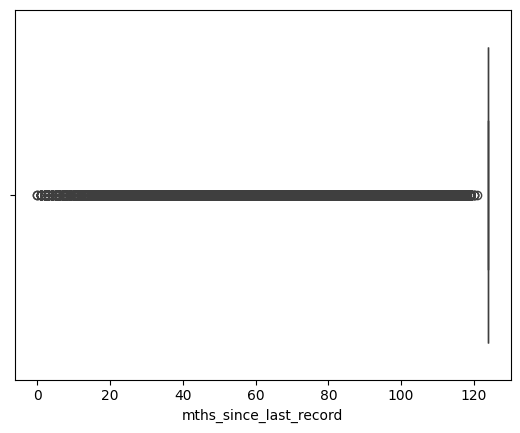

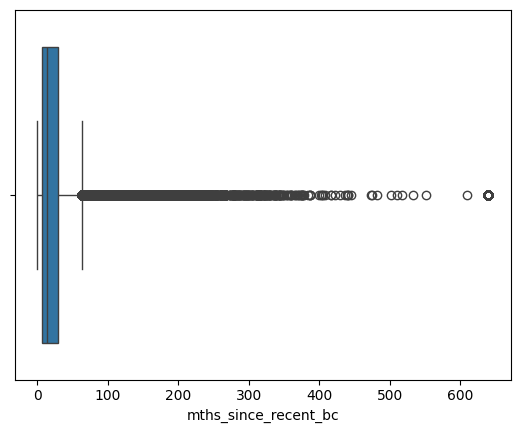

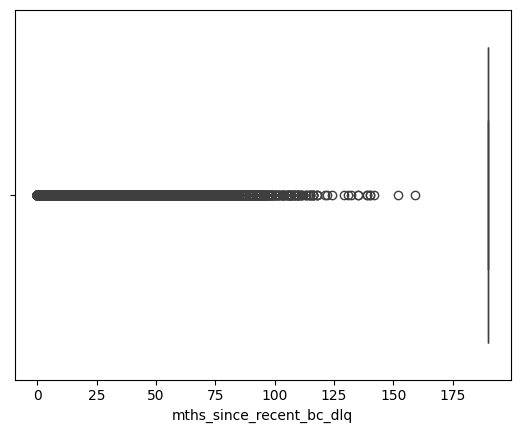

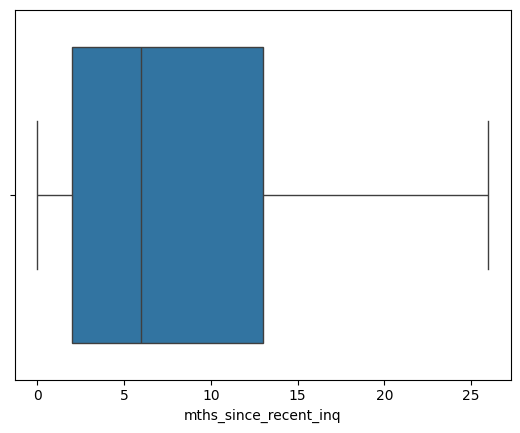

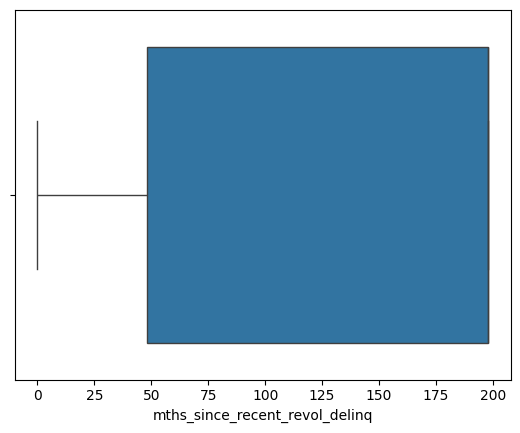

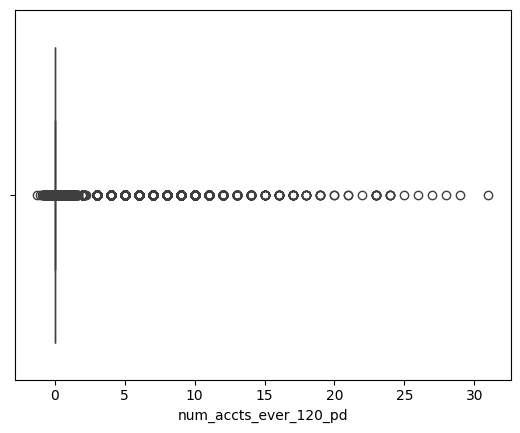

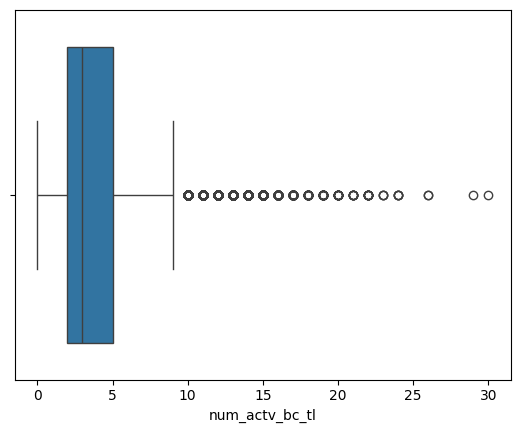

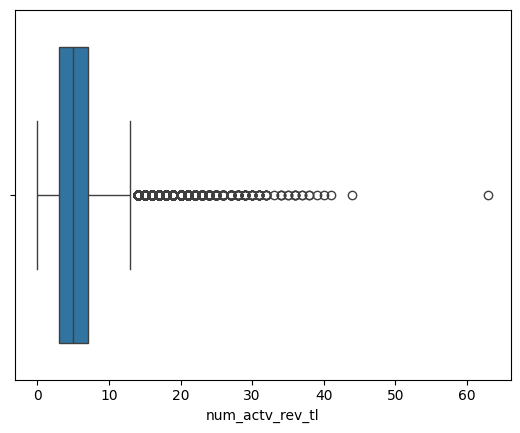

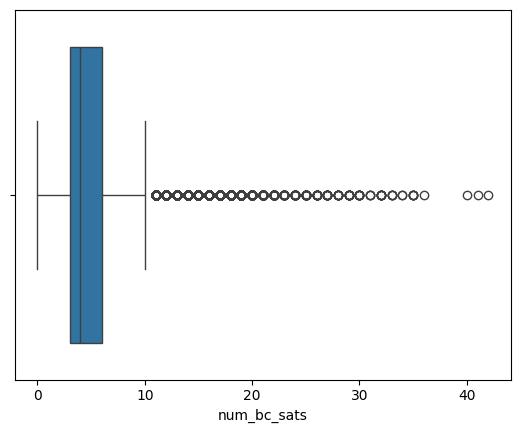

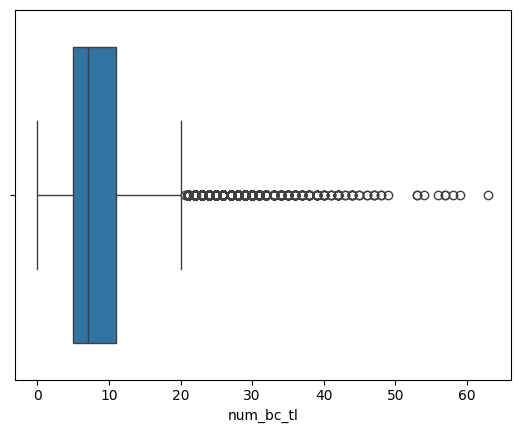

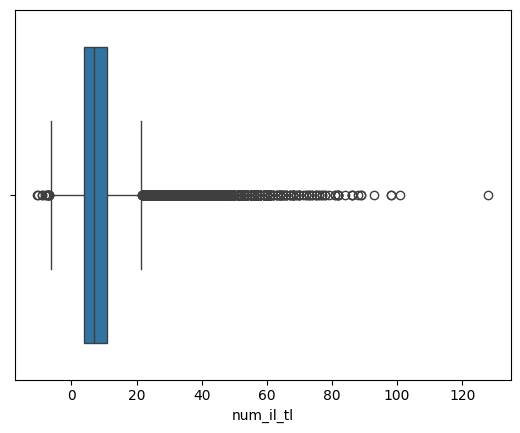

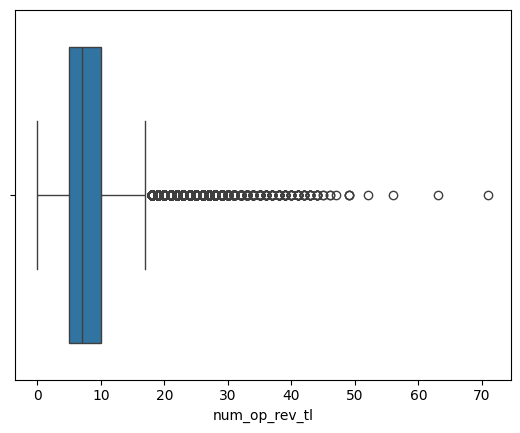

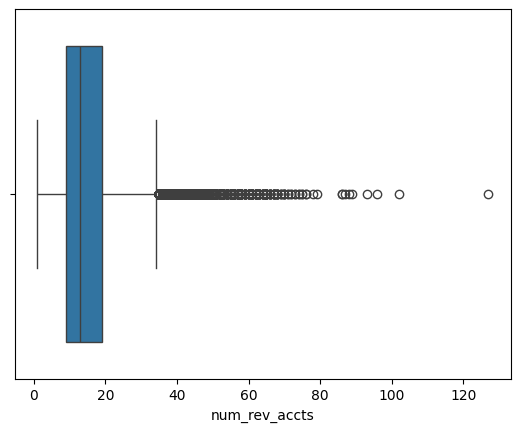

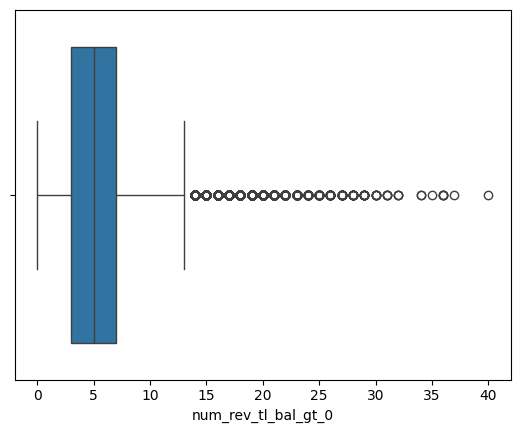

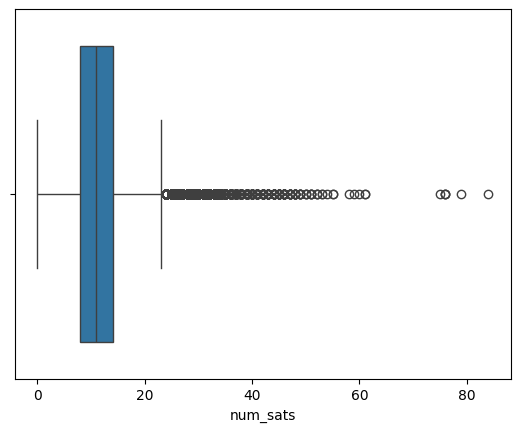

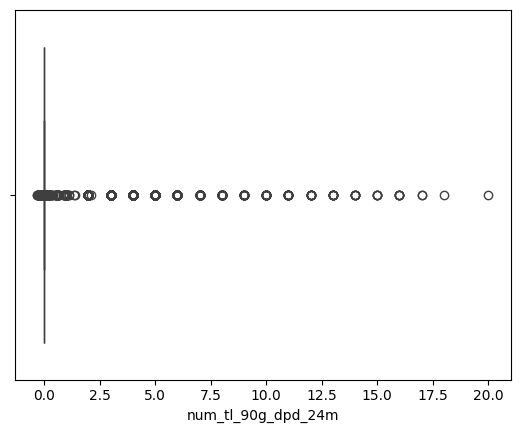

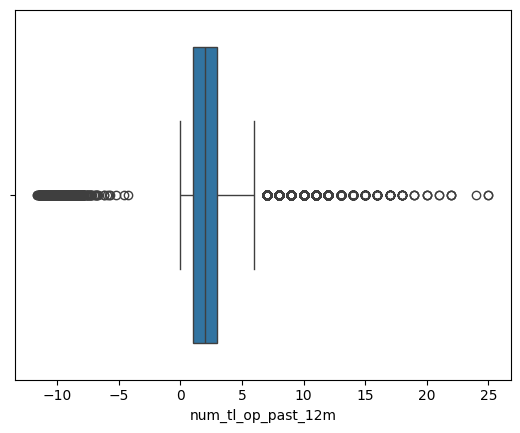

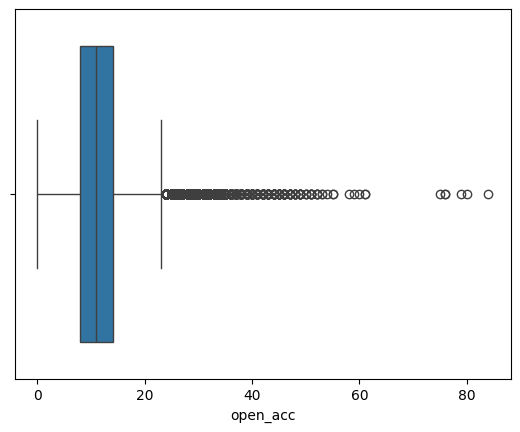

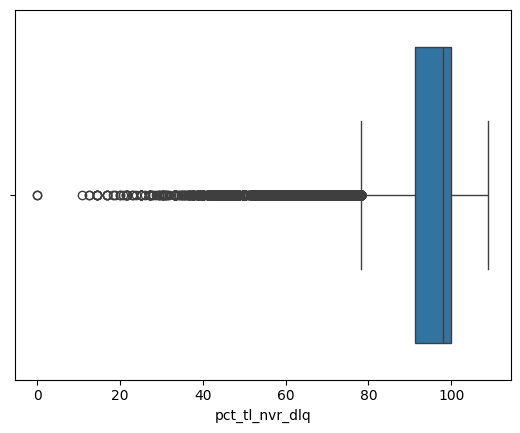

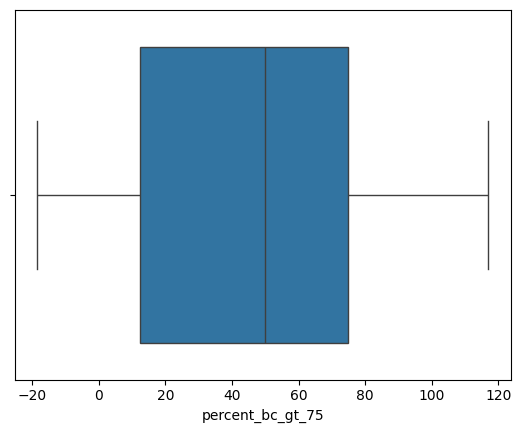

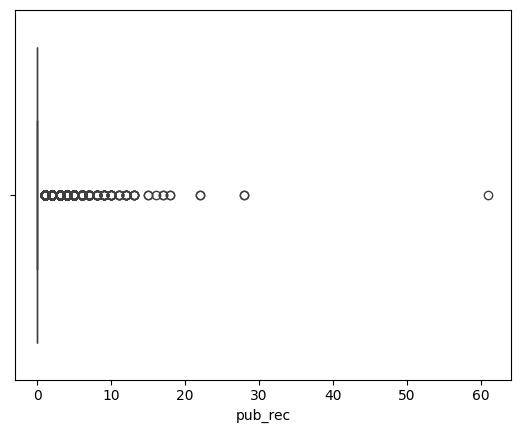

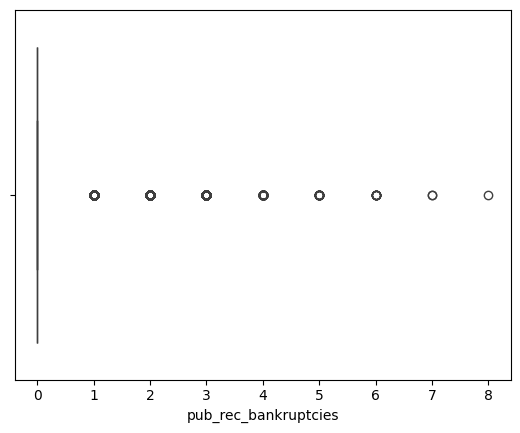

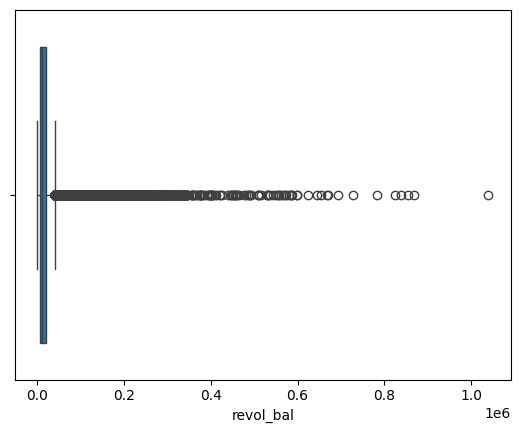

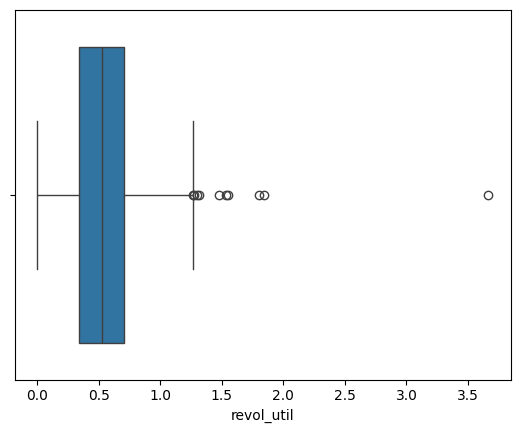

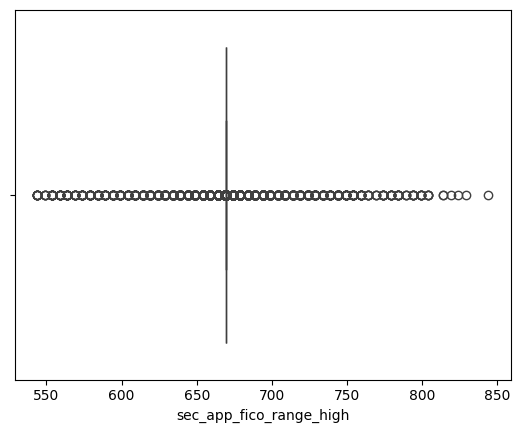

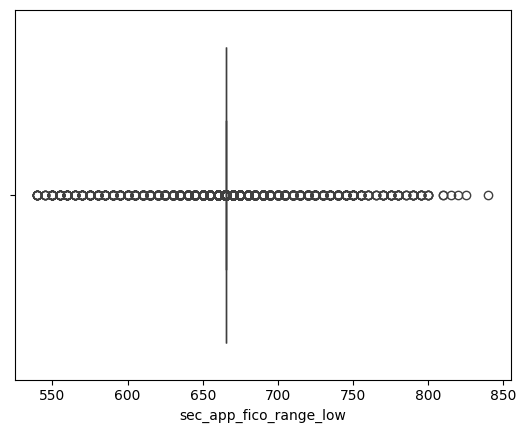

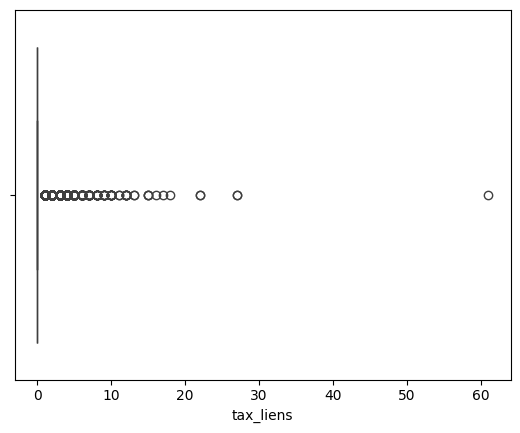

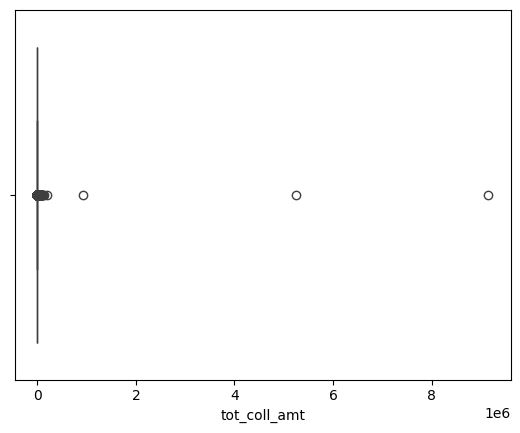

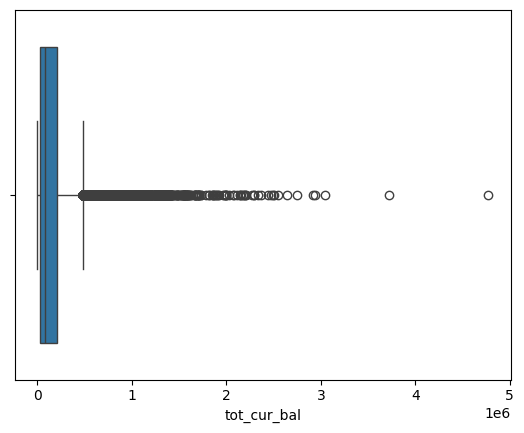

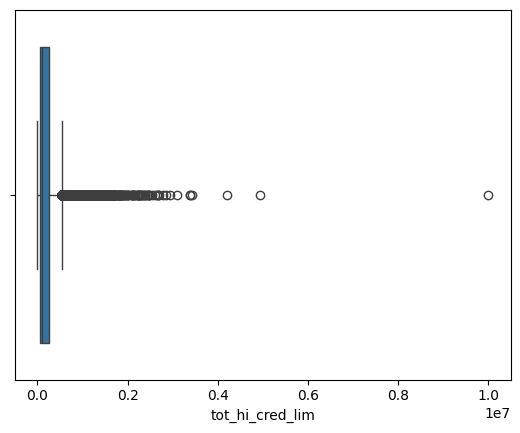

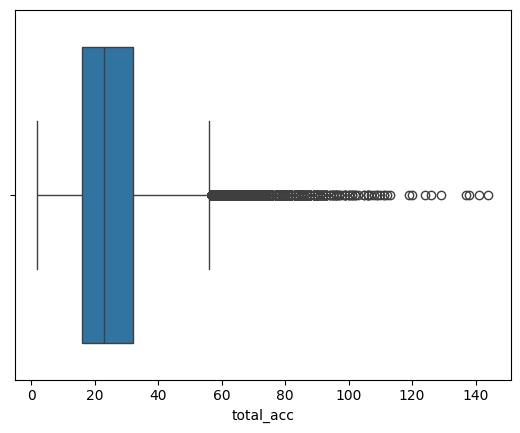

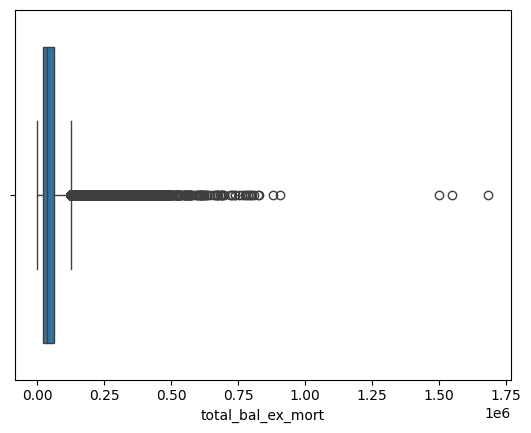

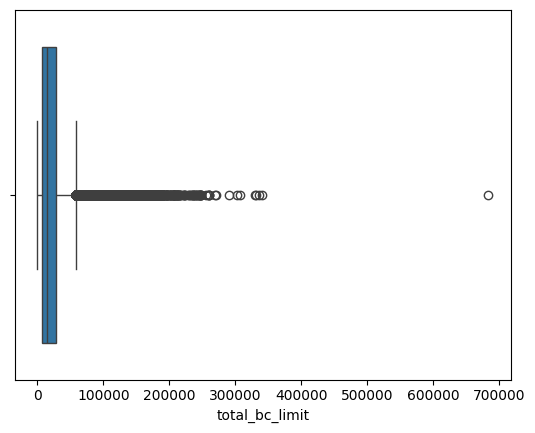

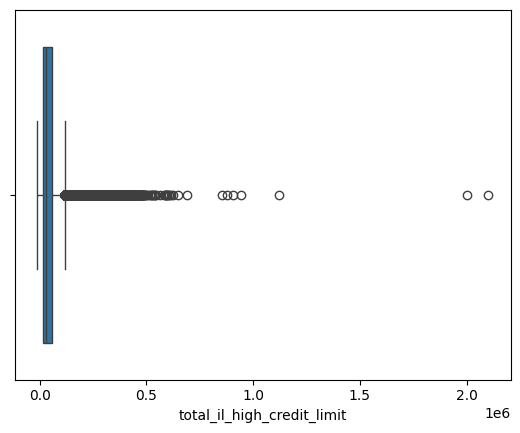

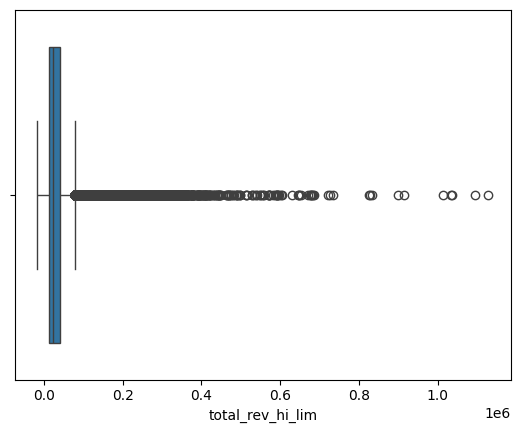

In [7]:
import seaborn as sns
for col in num_cols:
    sns.boxplot(data = loan_df, x = col)
    plt.show()

In [8]:
from scipy.stats import zscore
# Calculate Z-scores
z_scores = num_cols.apply(zscore)

# Filter out rows with any Z-scores > 3 or < -3
num_cols_no_outliers = num_cols[(z_scores < 3).all(axis=1)]
df_no_outliers = pd.concat([num_cols_no_outliers, loan_df.drop(columns=num_cols.columns)], axis=1)
df_no_outliers.dropna(inplace = True)

In [9]:
# Breaking out issue_d to month and year
df_no_outliers['year']=df_no_outliers['issue_d'].dt.year
df_no_outliers['month']=df_no_outliers['issue_d'].dt.month

In [10]:
# Converting some features to categorical for LightGBM
df_no_outliers['addr_state']=df_no_outliers['addr_state'].astype('category')
df_no_outliers['application_type']=df_no_outliers['application_type'].astype('category')
df_no_outliers['emp_length']=df_no_outliers['emp_length'].astype('category')
df_no_outliers['home_ownership']=df_no_outliers['home_ownership'].astype('category')
df_no_outliers['purpose']=df_no_outliers['purpose'].astype('category')
df_no_outliers['verification_status']=df_no_outliers['verification_status'].astype('category')
df_no_outliers['term']=df_no_outliers['term'].astype('category')

In [6]:
# Save model dataframe to a pickle file for easier reading
#df_no_outliers.to_pickle('model_df.pkl')
model_df = pd.read_pickle('model_df.pkl')

# Modeling

## First model: Light Gradient-Boosting Machine

### Using Optuna to find optimal parameters. Focusing on having models with high accuracy

In [7]:
import optuna
import lightgbm as lgb
import sklearn.metrics
from sklearn.model_selection import train_test_split

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    data, target = X,y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, stratify=target, random_state=42)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    #recall = sklearn.metrics.recall_score(valid_y, pred_labels)
    return accuracy#, recall

### Dropping a ton of columns that didn't really help the model. Call X.columns for final list of features used

In [8]:
X = model_df.drop(columns = ['term','term_ 60 months','emp_length','home_ownership', 'grade','sub_grade','fully_paid','installment','int_rate','zip_code','issue_d',
'year','purpose_credit_card','purpose_debt_consolidation','purpose_educational','purpose_home_improvement','purpose','application_type_Joint App',
'verification_status_Source Verified','verification_status','addr_state','application_type','pub_rec','tax_liens',
'pub_rec_bankruptcies','num_op_rev_tl','num_sats','total_bal_ex_mort','mo_sin_rcnt_rev_tl_op',
'mths_since_recent_revol_delinq','tot_coll_amt','pct_tl_nvr_dlq','num_rev_accts','num_bc_tl','inq_last_6mths',
'num_bc_sats','open_acc','emp_length_10+ years','emp_length_2-4 years', 'emp_length_5-9 years','purpose_house', 
'purpose_major_purchase', 'purpose_medical','purpose_moving', 'purpose_other', 'purpose_renewable_energy',
'purpose_small_business', 'purpose_vacation', 'purpose_wedding','acc_now_delinq','num_accts_ever_120_pd','delinq_2yrs','chargeoff_within_12_mths',
'collections_12_mths_ex_med','delinq_amnt','mo_sin_old_il_acct','home_ownership_MORTGAGE',
'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN','home_ownership_RENT'])
y = model_df['fully_paid']

In [9]:
X.columns

Index(['acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy',
       'bc_util', 'dti', 'fico_range_high', 'fico_range_low',
       'last_fico_range_high', 'last_fico_range_low', 'loan_amnt',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_last_major_derog',
       'mths_since_last_record', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_il_tl', 'num_rev_tl_bal_gt_0',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'percent_bc_gt_75',
       'revol_bal', 'revol_util', 'sec_app_fico_range_high',
       'sec_app_fico_range_low', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc',
       'total_bc_limit', 'total_il_high_credit_limit', 'total_rev_hi_lim',
       'credit_line_age', 'verification_status_Verified', 'month'],
      dtype='object')

In [10]:
study = optuna.create_study(directions=['maximize'])
study.optimize(objective, n_trials=100)

[I 2024-11-23 17:35:46,168] A new study created in memory with name: no-name-95f49523-28ba-4e0a-a329-68a0932ec3a7
[I 2024-11-23 17:35:50,181] Trial 0 finished with value: 0.9047632565005109 and parameters: {'lambda_l1': 0.24551462013047626, 'lambda_l2': 8.575095643844727e-06, 'num_leaves': 185, 'feature_fraction': 0.9898885043380595, 'bagging_fraction': 0.5760705511525697, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 0 with value: 0.9047632565005109.
[I 2024-11-23 17:35:54,449] Trial 1 finished with value: 0.9054161462473033 and parameters: {'lambda_l1': 2.356911689765149e-06, 'lambda_l2': 2.0001917601733077e-06, 'num_leaves': 166, 'feature_fraction': 0.6691855652117926, 'bagging_fraction': 0.8576028814509548, 'bagging_freq': 1, 'min_child_samples': 75}. Best is trial 1 with value: 0.9054161462473033.
[I 2024-11-23 17:35:59,460] Trial 2 finished with value: 0.9031452253888952 and parameters: {'lambda_l1': 2.109231687853144e-08, 'lambda_l2': 0.002818076448057587, 'num_leav

In [11]:
study.best_trial

FrozenTrial(number=32, state=1, values=[0.9084535028954241], datetime_start=datetime.datetime(2024, 11, 23, 17, 37, 10, 201260), datetime_complete=datetime.datetime(2024, 11, 23, 17, 37, 11, 844591), params={'lambda_l1': 8.417871450653168, 'lambda_l2': 2.1766580260398056, 'num_leaves': 59, 'feature_fraction': 0.6652604083220923, 'bagging_fraction': 0.7437274443616042, 'bagging_freq': 3, 'min_child_samples': 25}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=5, step

In [12]:
trialbst = optuna.trial.Trial(study,32)
trialbst.params

{'lambda_l1': 8.417871450653168,
 'lambda_l2': 2.1766580260398056,
 'num_leaves': 59,
 'feature_fraction': 0.6652604083220923,
 'bagging_fraction': 0.7437274443616042,
 'bagging_freq': 3,
 'min_child_samples': 25}

In [13]:
# Splitting into train/test splits and stratifying the target
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.25, random_state=4, stratify=y)

### These params were found from a previous study, but they worked well. Looking at training/testing accuracy scores as well as the logloss for evaluation

Training accuracy 0.9215
Testing accuracy 0.9088


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

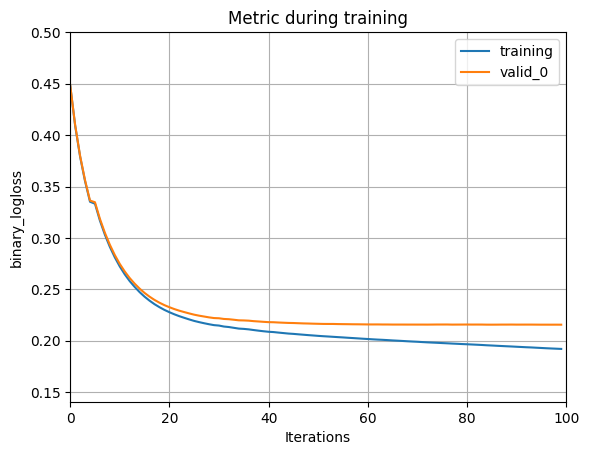

In [14]:
lgbm = lgb.LGBMClassifier(lambda_l1= 8.417871450653168,
    lambda_l2= 2.1766580260398056,
    num_leaves= 59,
    feature_fraction= 0.6652604083220923,
    bagging_fraction= 0.7437274443616042,
    bagging_freq= 3,
    min_child_samples= 25)
lgbm.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
print('Training accuracy {:.4f}'.format(lgbm.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm.score(X_test,y_test)))
lgb.plot_metric(lgbm)

## Feature Importance using LightGBM's plot_importance package

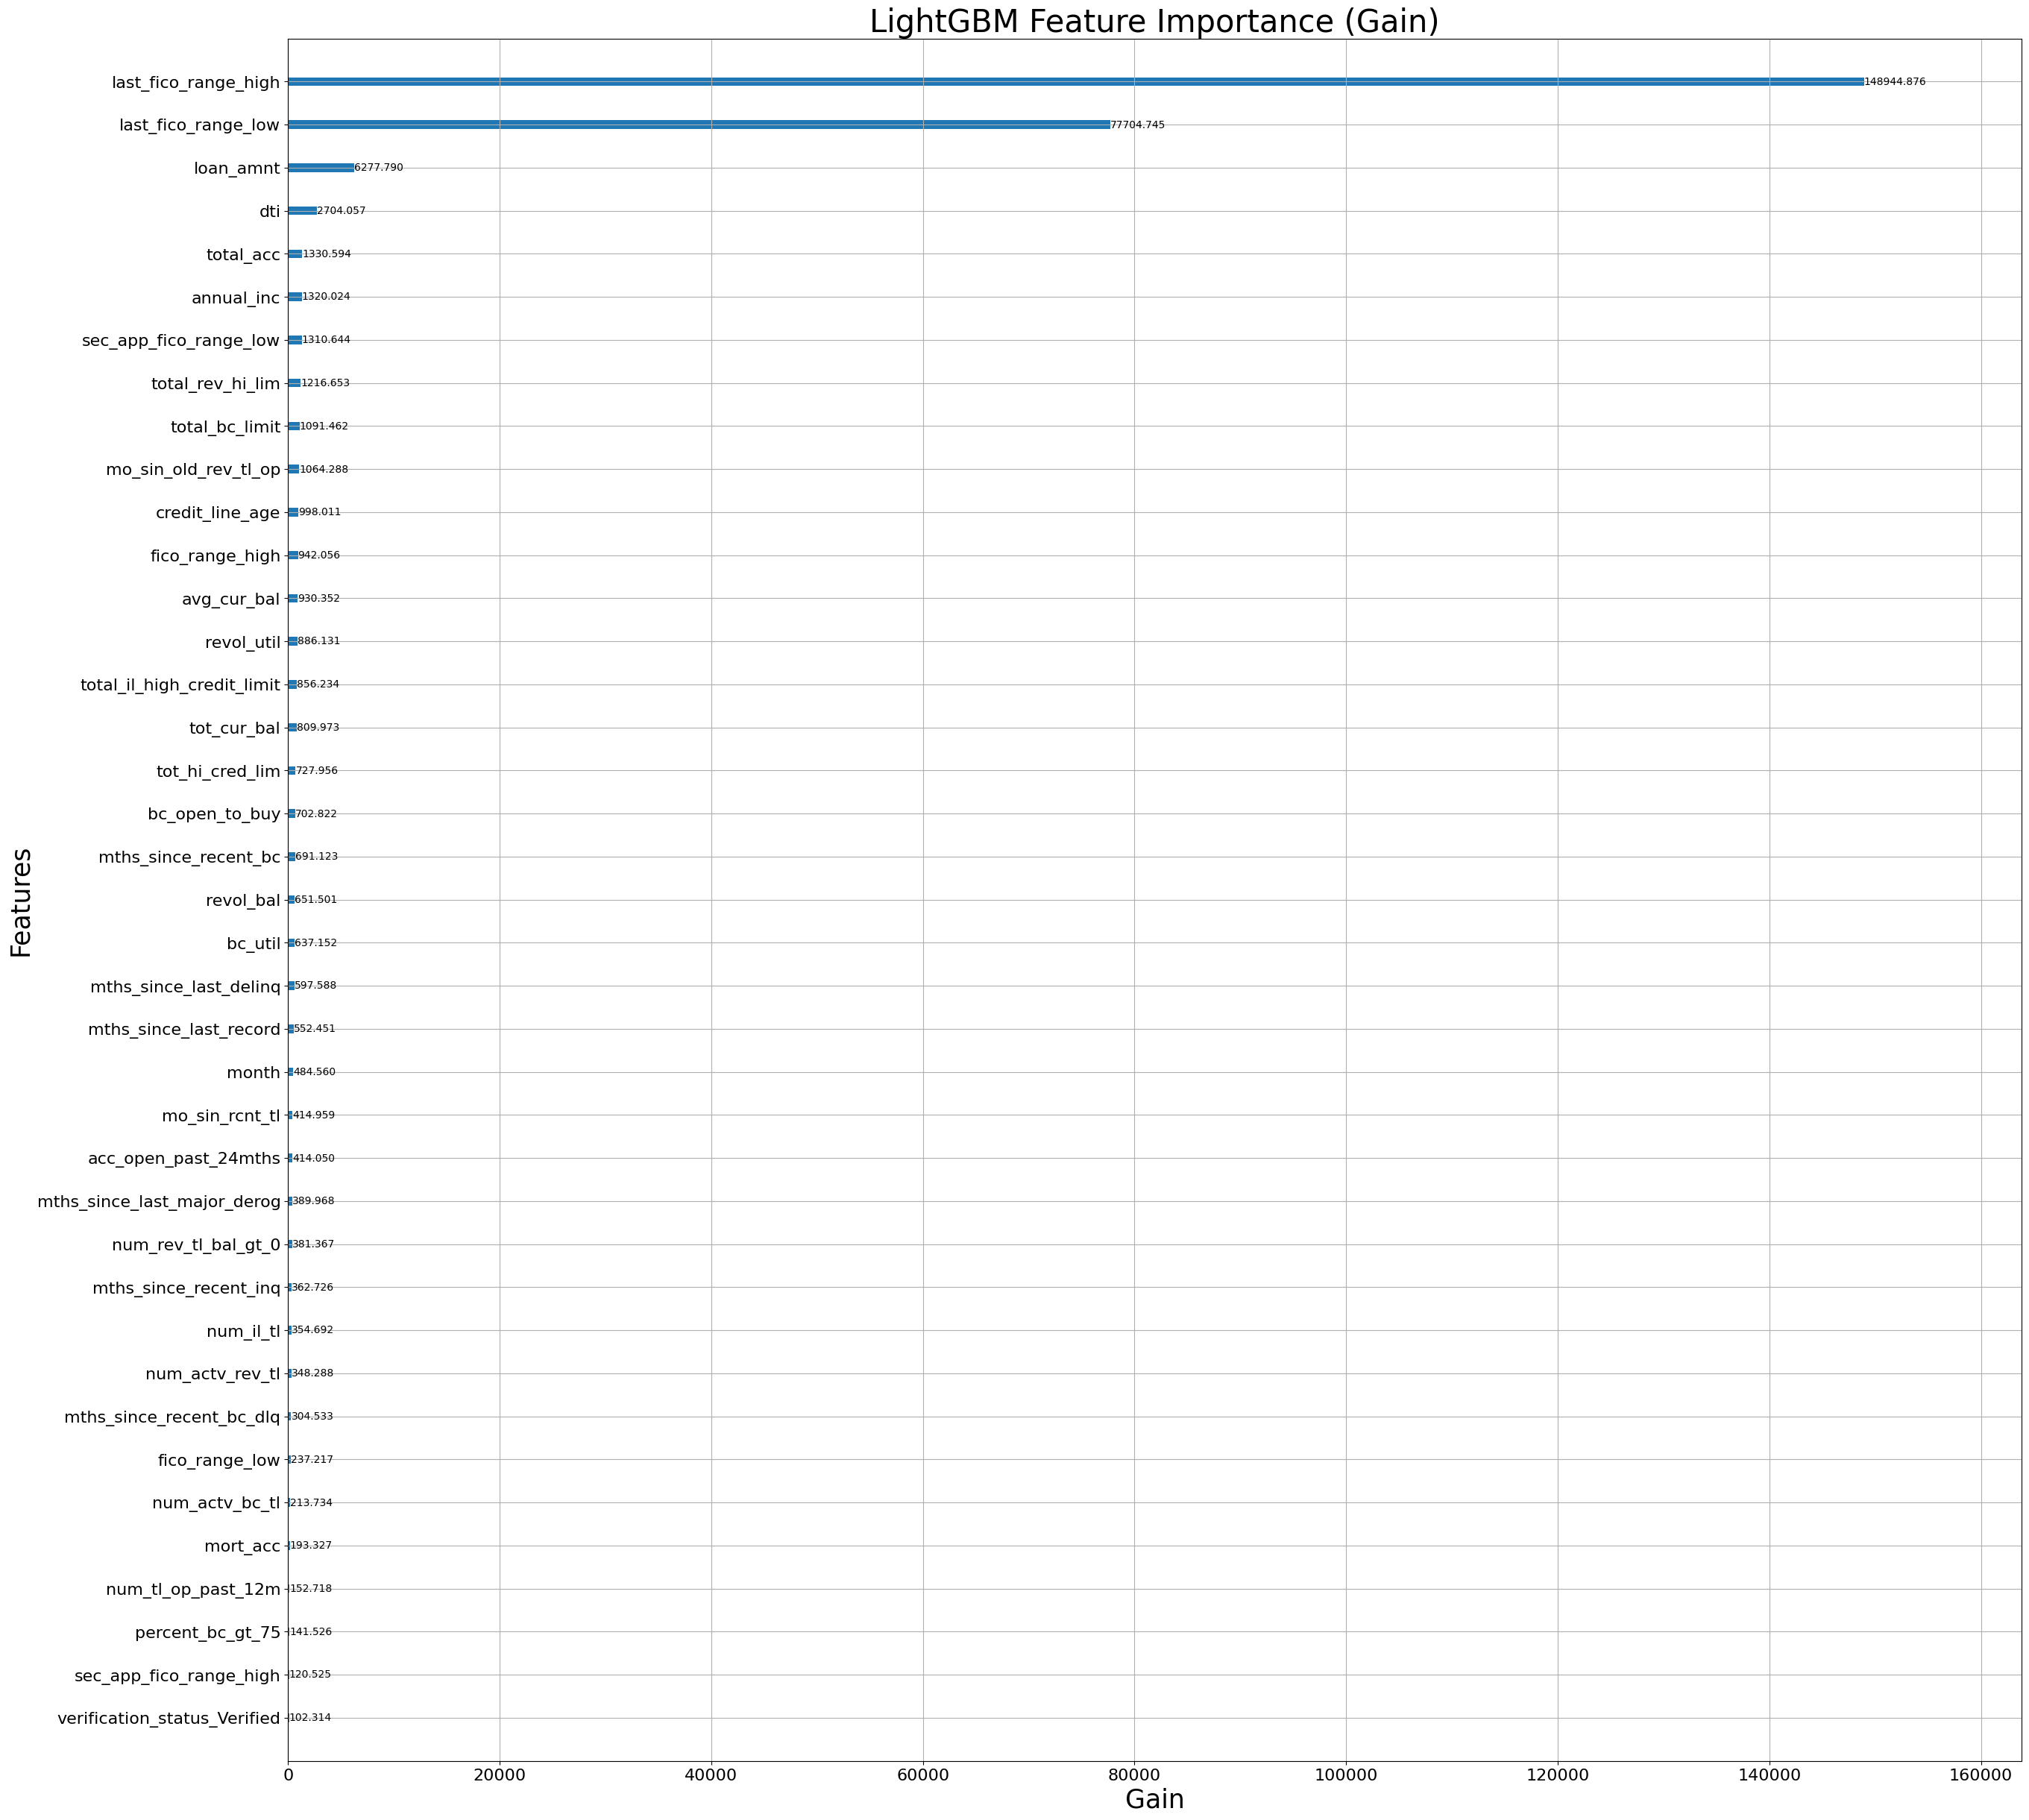

In [35]:
lgb.plot_importance(lgbm, importance_type="gain", figsize=(30,30), title="LightGBM Feature Importance (Gain)")
plt.title("LightGBM Feature Importance (Gain)", fontsize=30)
plt.xlabel("Gain", fontsize=25) 
plt.ylabel("Features", fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Second model: XGBoost

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Train Accuracy: 0.9139
Test Accuracy: 0.9092


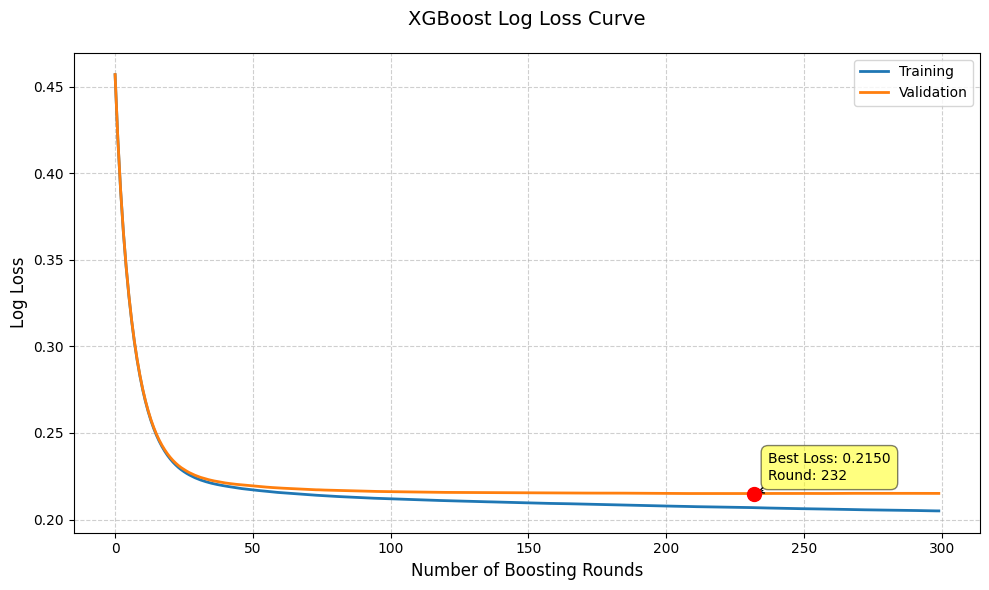

In [78]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Initialize the XGBoost classifier with eval_metric
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200,300, 400,500],
    'max_depth': [3, 5, 10,20],
    'learning_rate': [0.01, 0.1, 1]
}

# Get best parameters from GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_

# Create a new model with best parameters and eval_set for tracking
final_model = xgb.XGBClassifier(
    **best_params,
    eval_metric='logloss',
    random_state=42
)

# Create evaluation set
eval_set = [(X_train, y_train), (X_test, y_test)]

# Fit the model with evaluation set
final_model.fit(
    X_train, 
    y_train,
    eval_set=eval_set,
    verbose=False
)

# Get evaluation results
results = final_model.evals_result()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training and validation curves
plt.plot(range(len(results['validation_0']['logloss'])), 
         results['validation_0']['logloss'], 
         label='Training', 
         linewidth=2)
plt.plot(range(len(results['validation_1']['logloss'])), 
         results['validation_1']['logloss'], 
         label='Validation', 
         linewidth=2)

# Customize the plot
plt.title('XGBoost Log Loss Curve', fontsize=14, pad=20)
plt.xlabel('Number of Boosting Rounds', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.legend(fontsize=10)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Format y-axis to show only 2 decimal places
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

# Customize tick sizes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Find and plot the minimum validation loss point
val_loss = results['validation_1']['logloss']
min_val_loss = min(val_loss)
min_val_loss_idx = val_loss.index(min_val_loss)

plt.scatter(min_val_loss_idx, 
           min_val_loss, 
           color='red', 
           s=100, 
           zorder=5)

# Add annotation for minimum point
plt.annotate(f'Best Loss: {min_val_loss:.4f}\nRound: {min_val_loss_idx}',
            xy=(min_val_loss_idx, min_val_loss),
            xytext=(10, 10),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Adjust layout
plt.tight_layout()

# Print accuracies
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Best Hyperparameters:", best_params)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.show()

## Feature Importance of XGBoost model

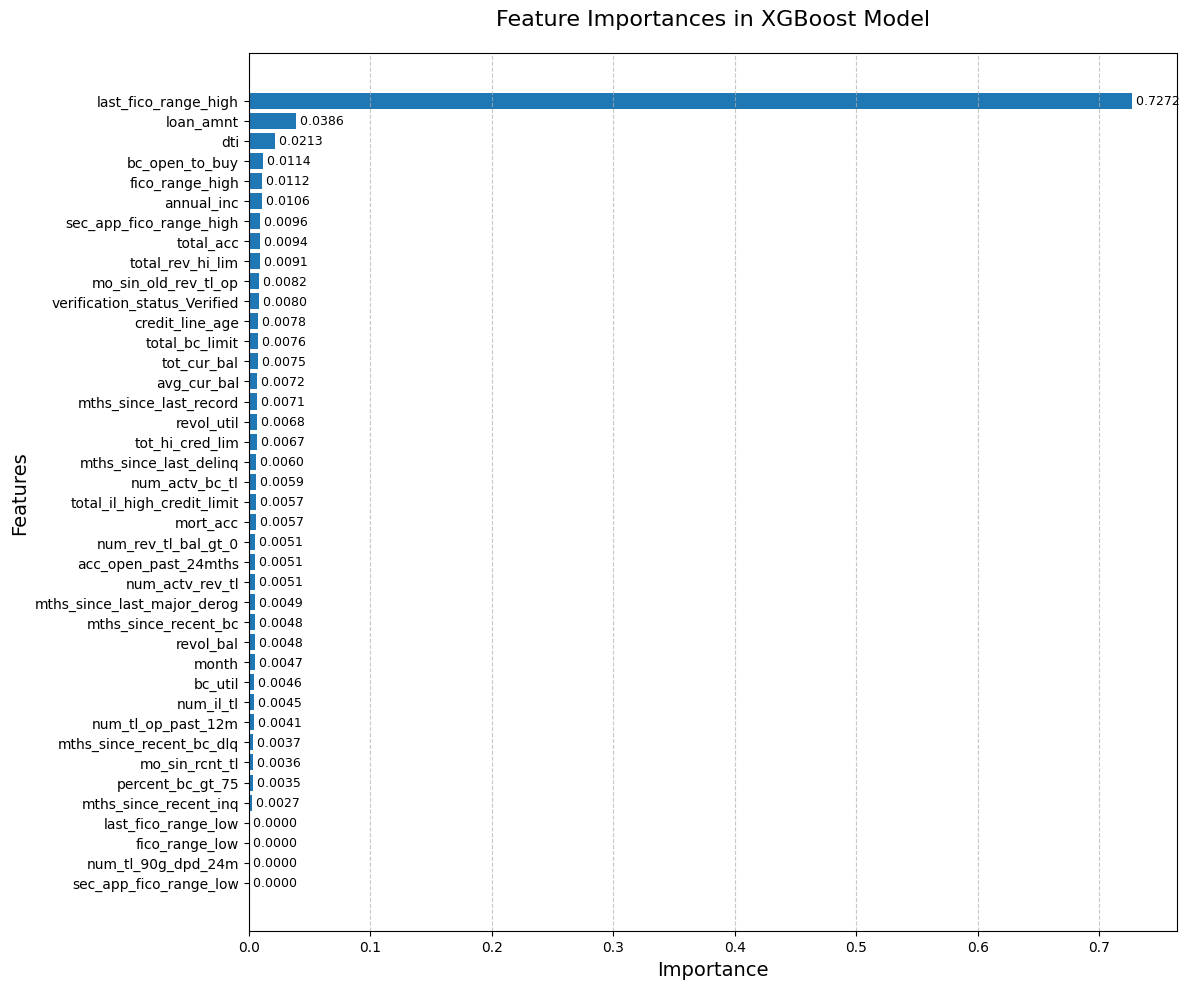

In [74]:
# Get feature importances
importances = final_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)

# Get feature names (assuming X_train is a DataFrame, otherwise use range(len(importances)))
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(len(importances))]

# Create plot
plt.figure(figsize=(12, 10))
plt.title("Feature Importances in XGBoost Model", fontsize=16, pad=20)
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), [feature_names[i] for i in indices], fontsize=10)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)

# Add value labels at the end of each bar
for i, v in enumerate(importances[indices]):
    plt.text(v, i, f" {v:.4f}", va='center', fontsize=9)

# Customize the plot
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

## Partial Dependency Plots

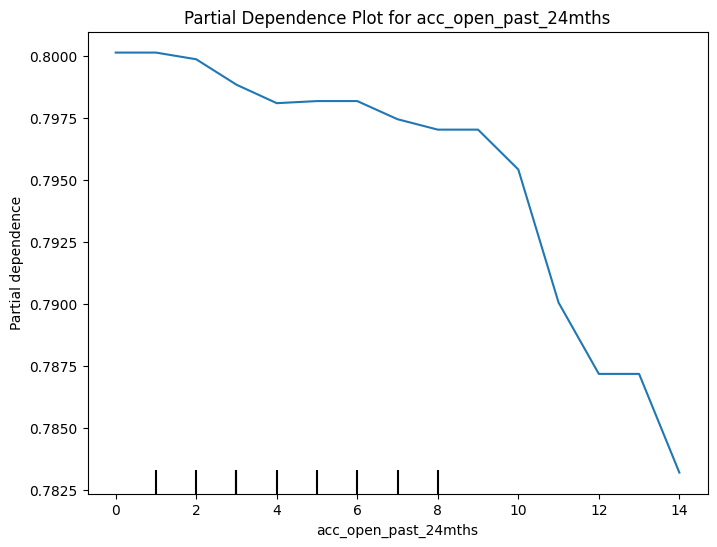

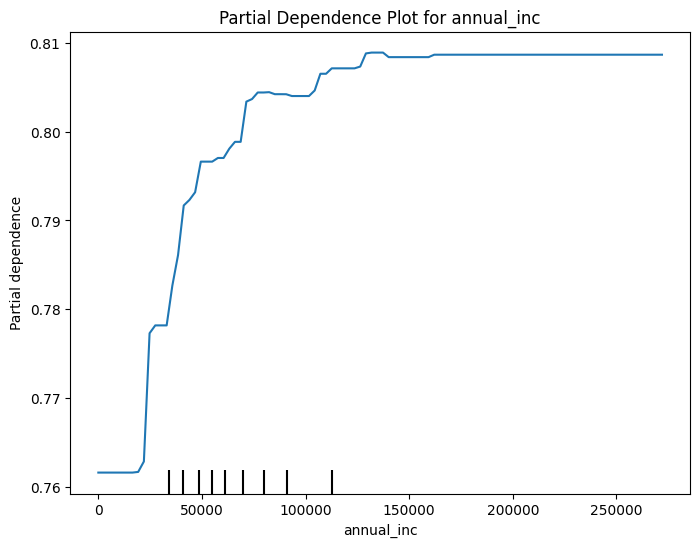

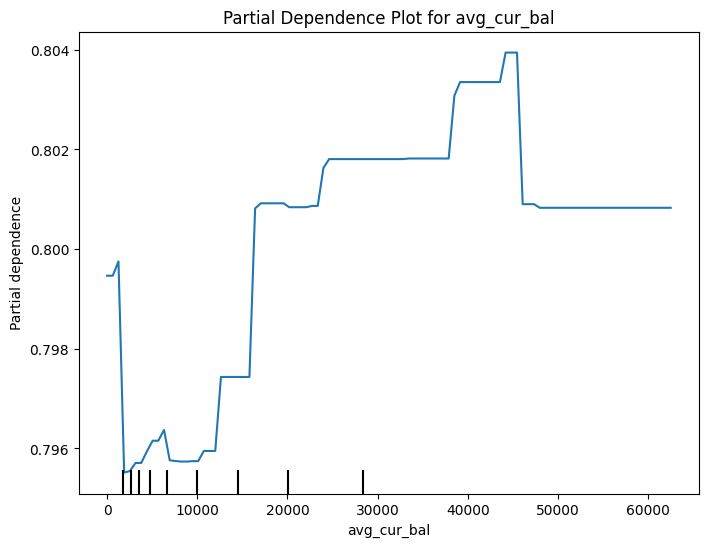

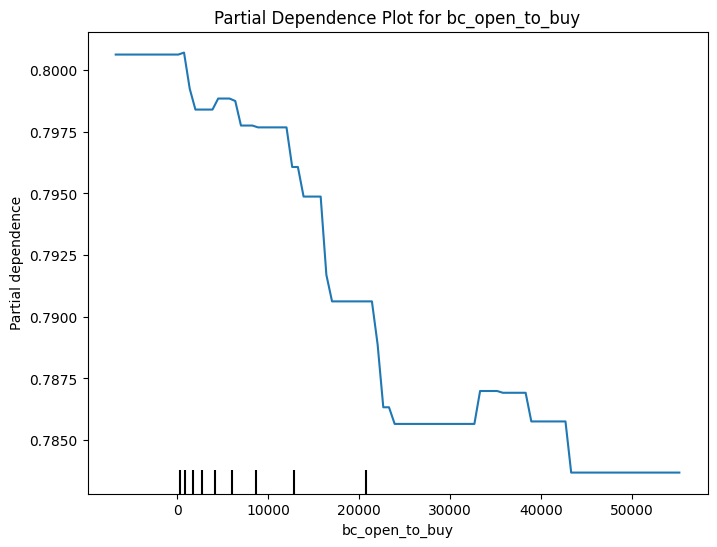

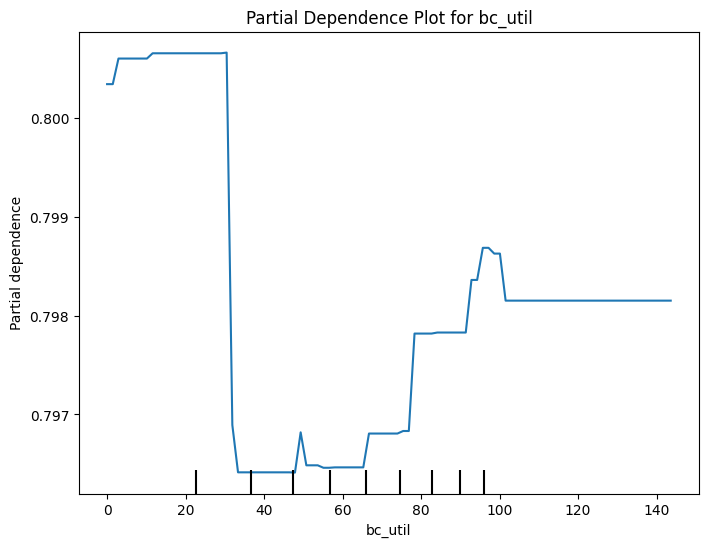

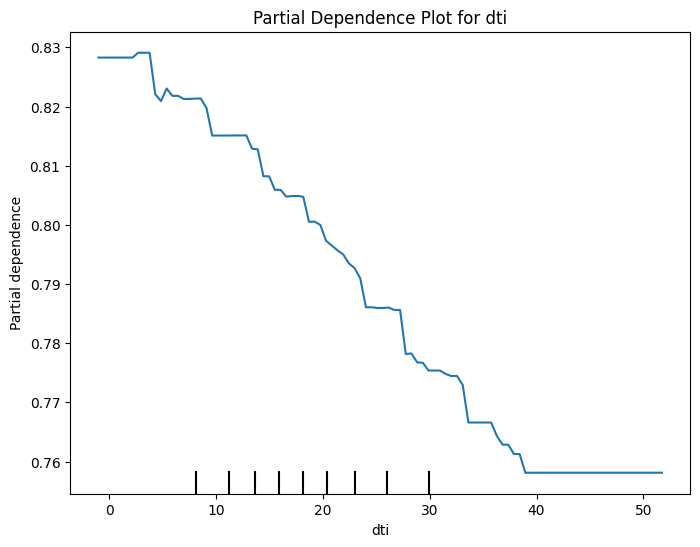

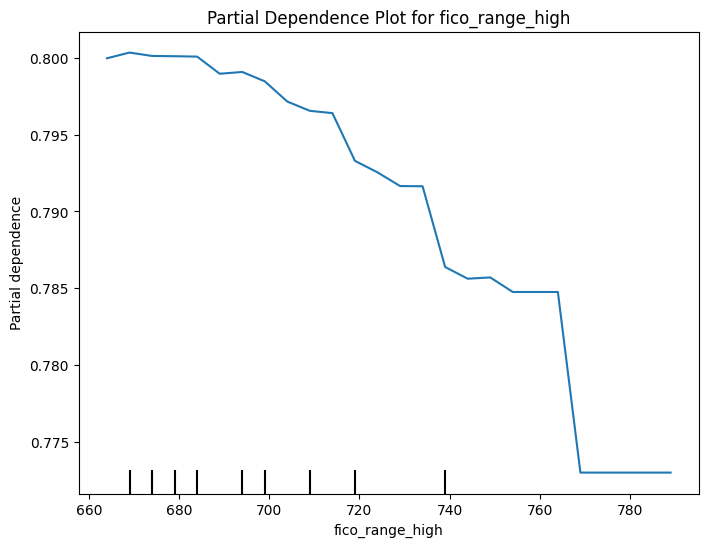

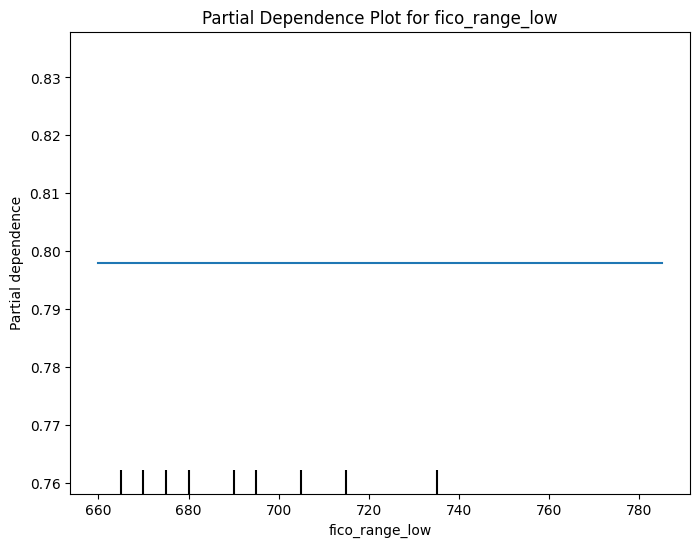

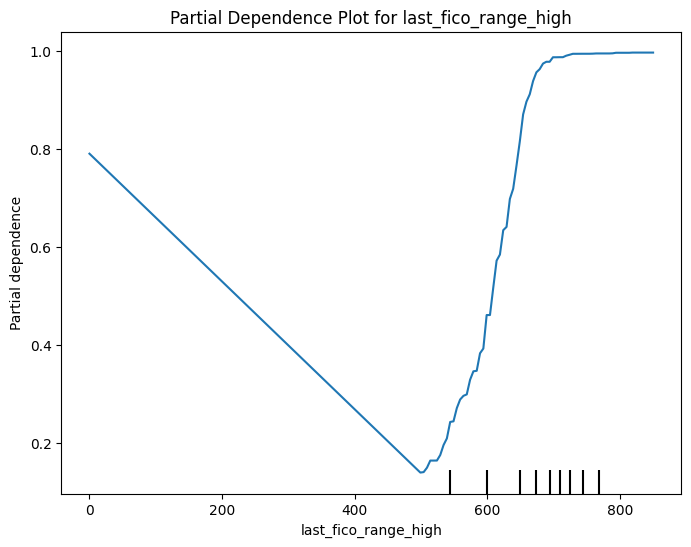

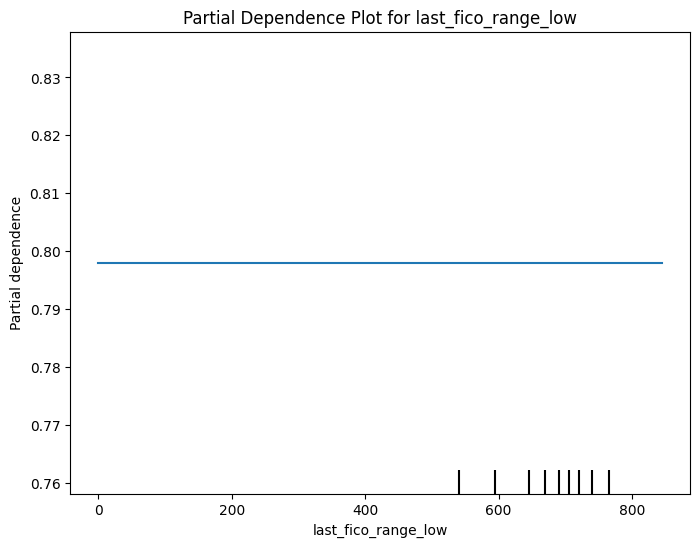

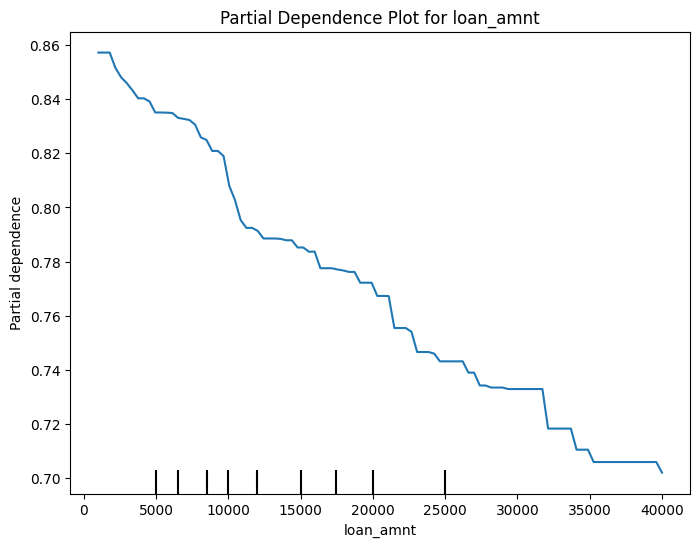

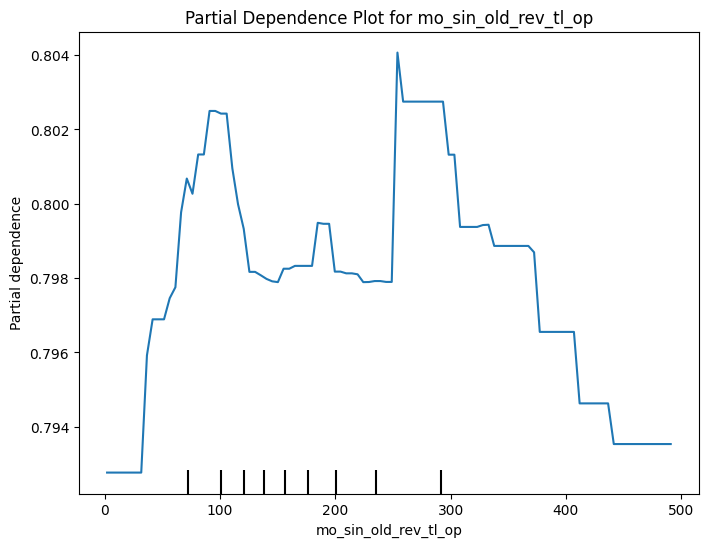

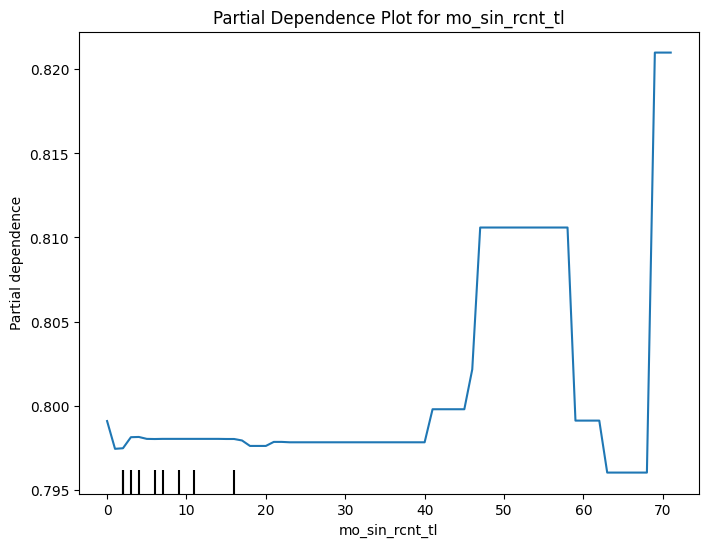

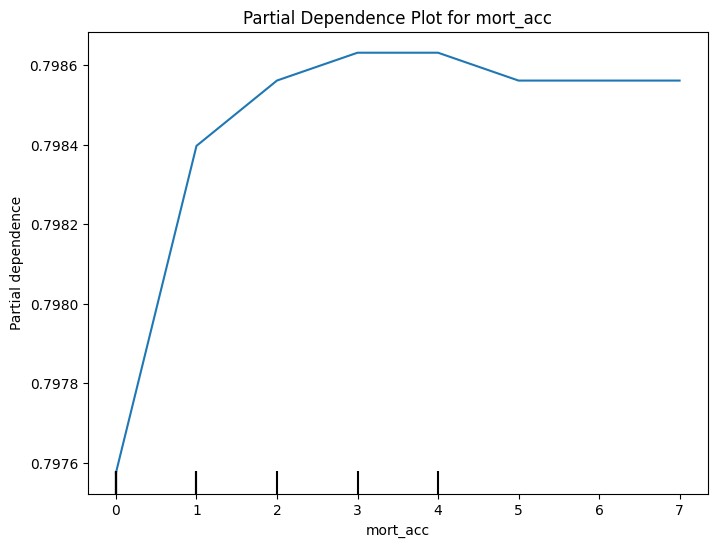

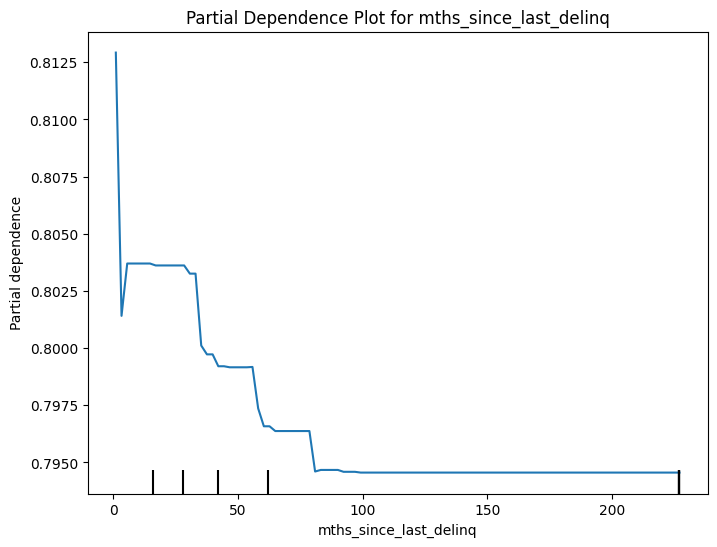

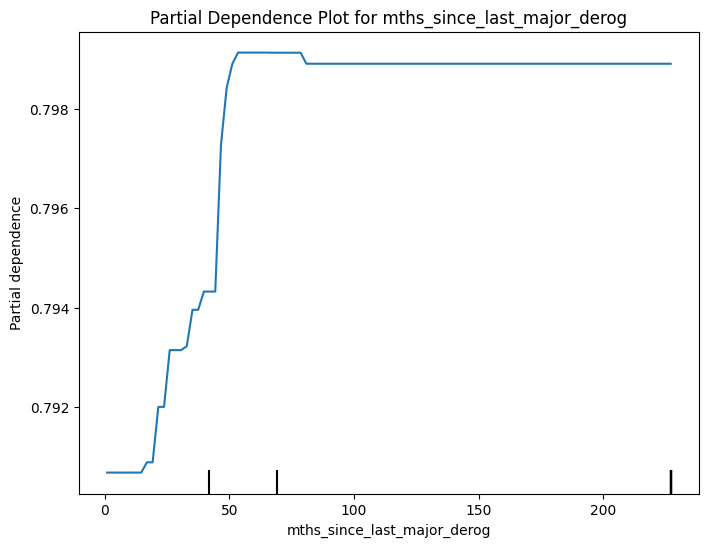

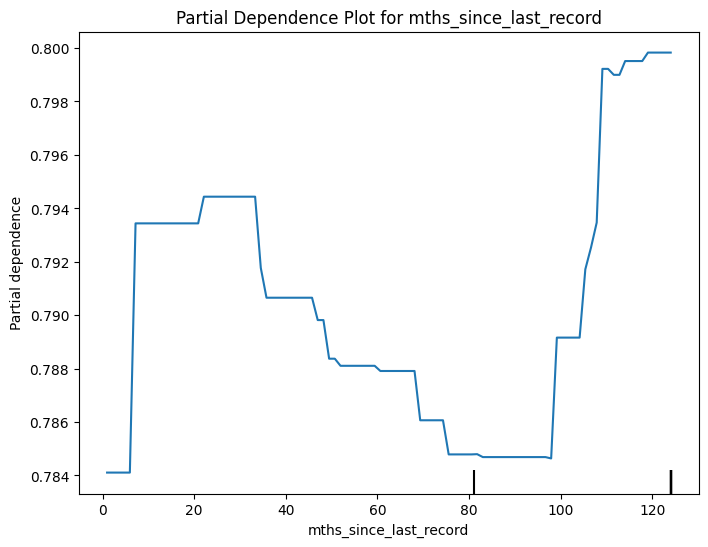

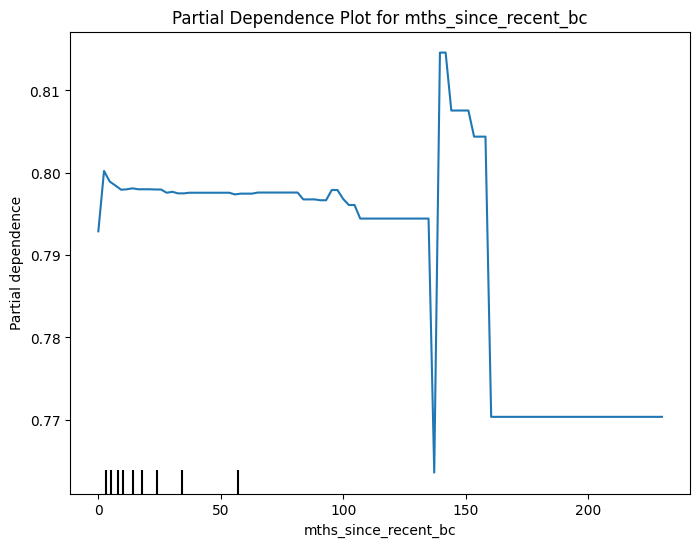

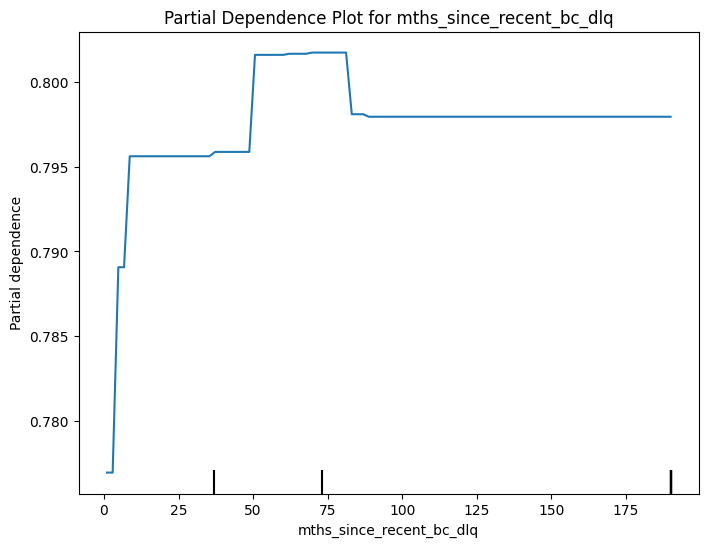

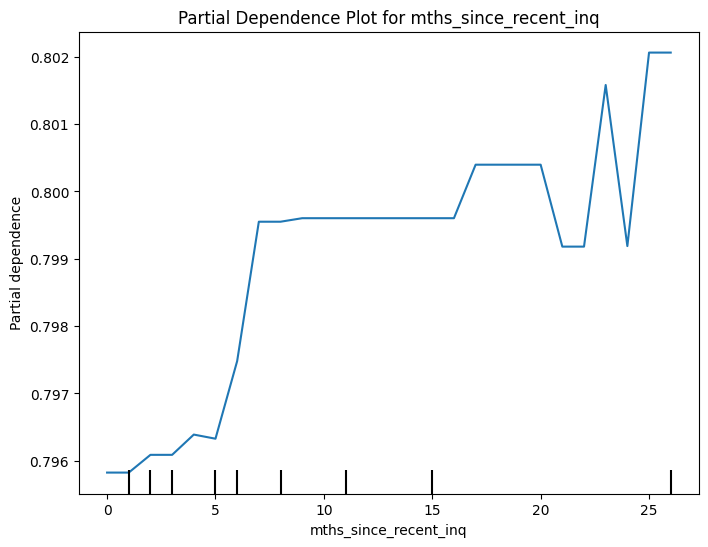

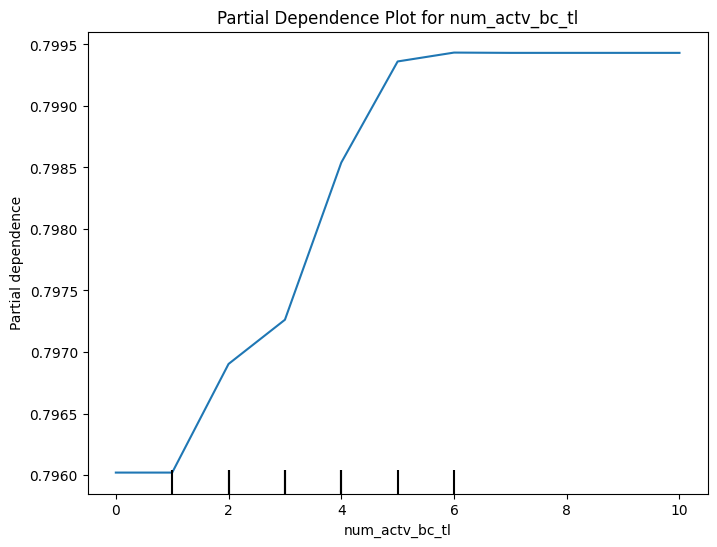

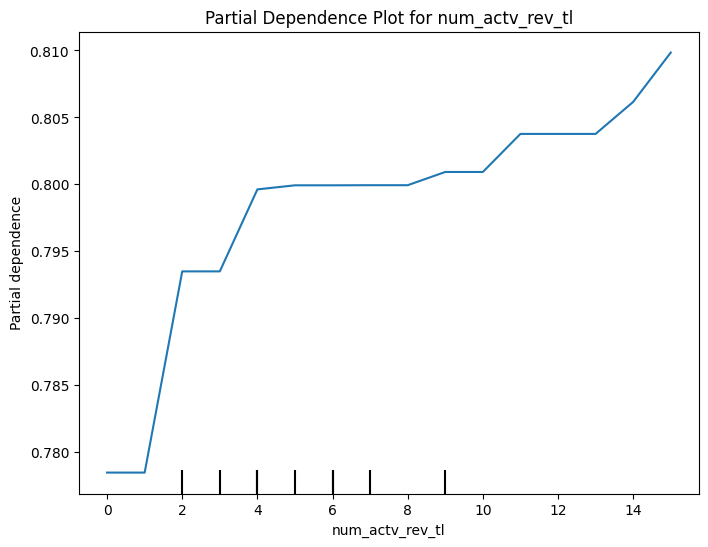

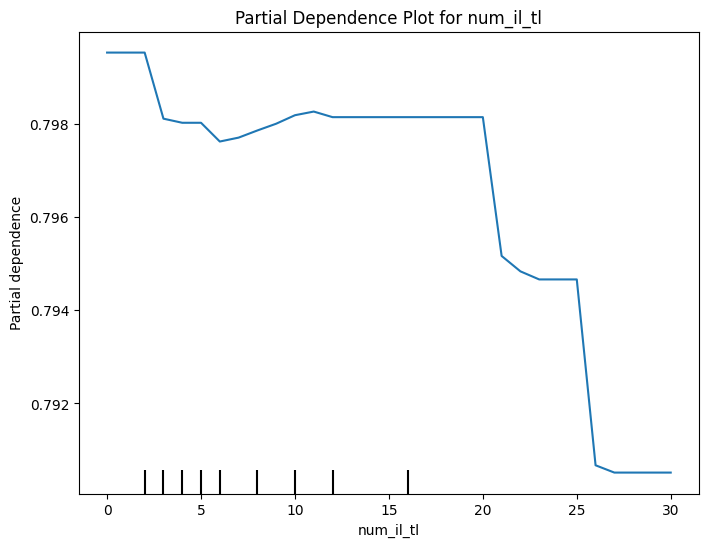

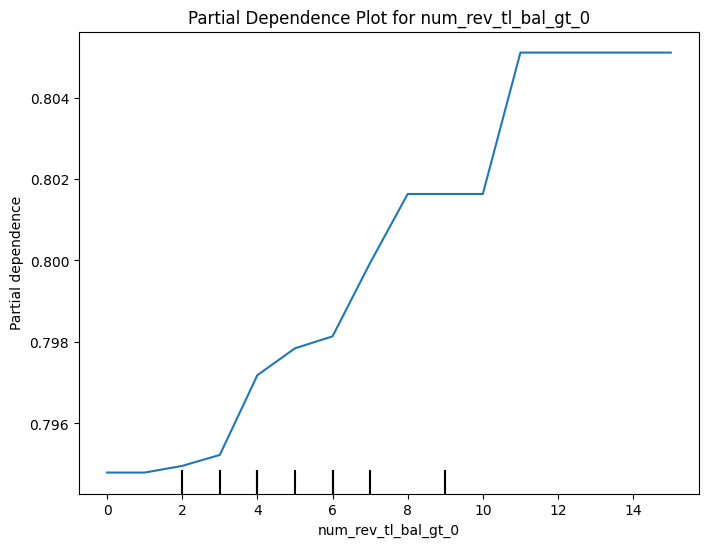

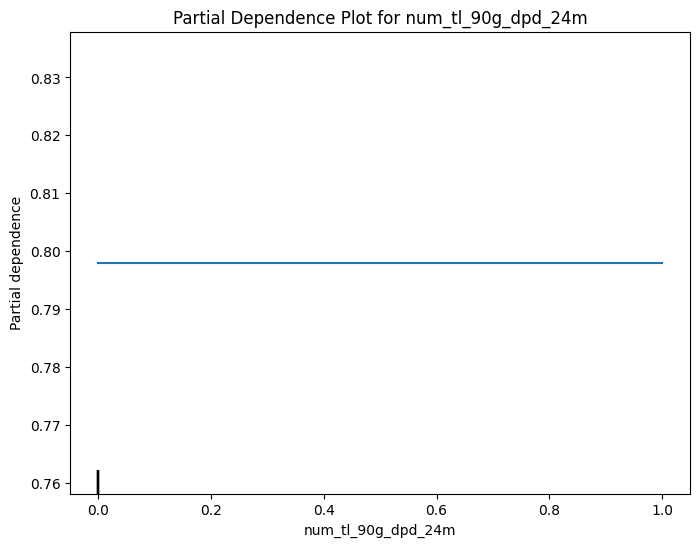

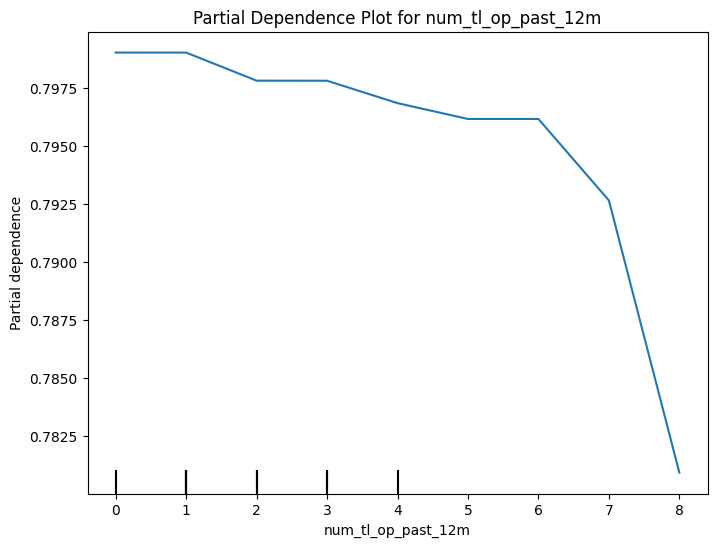

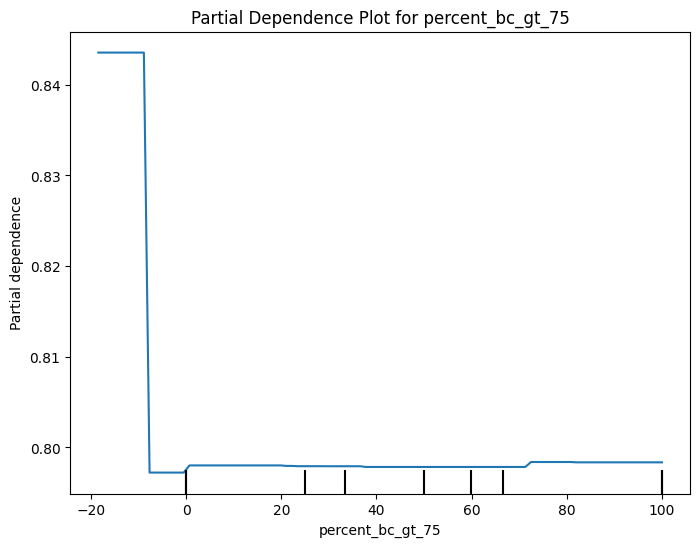

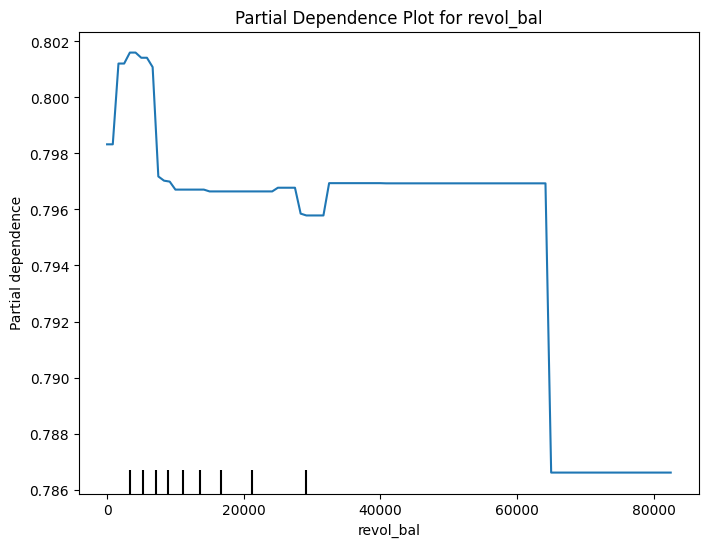

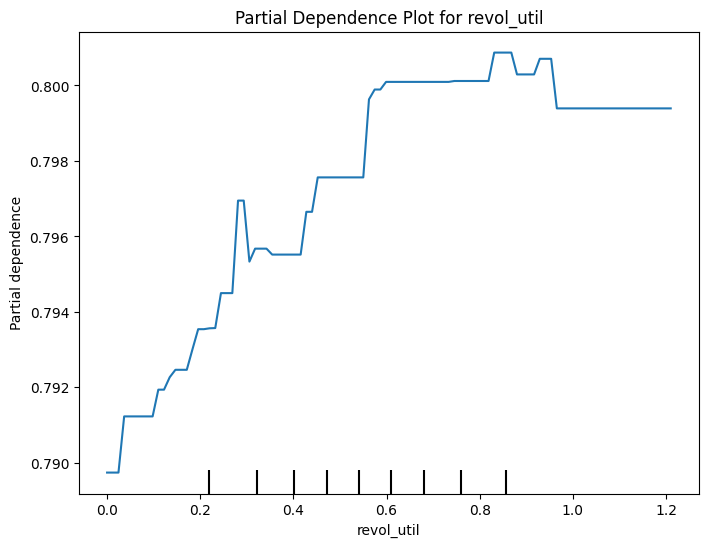

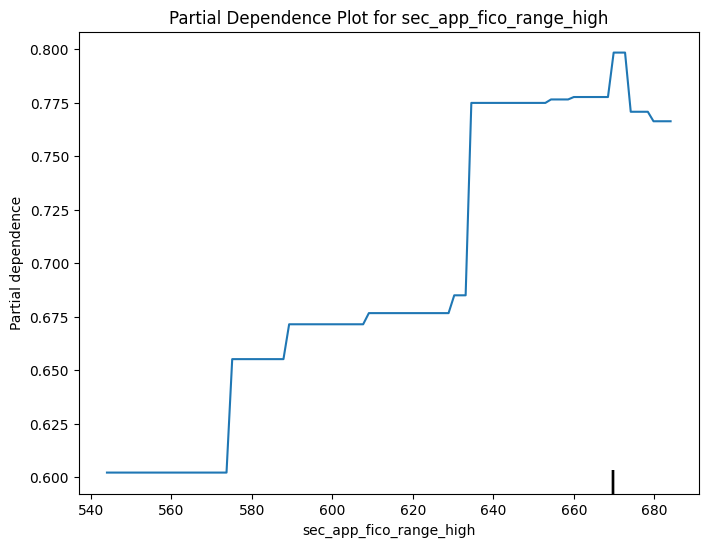

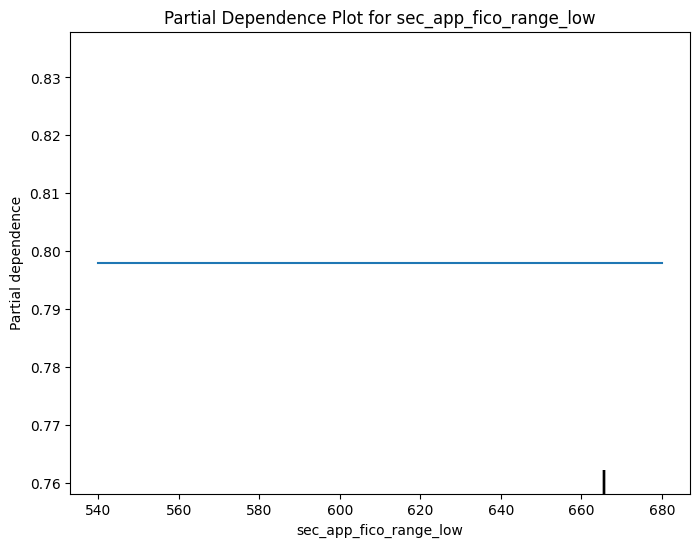

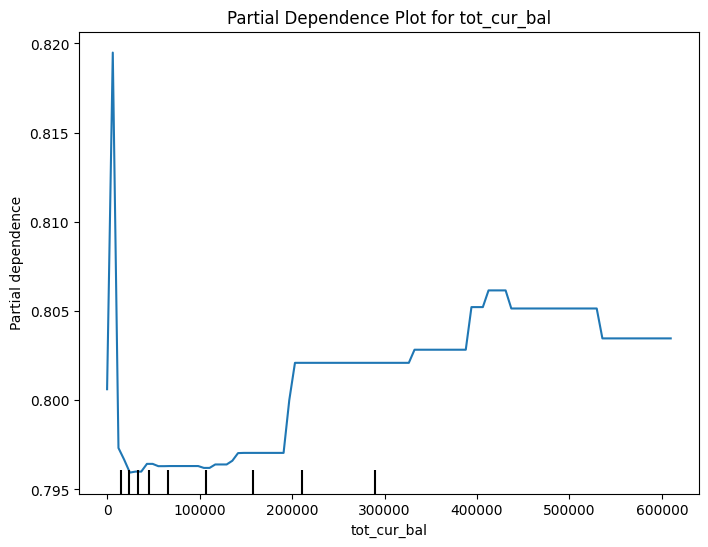

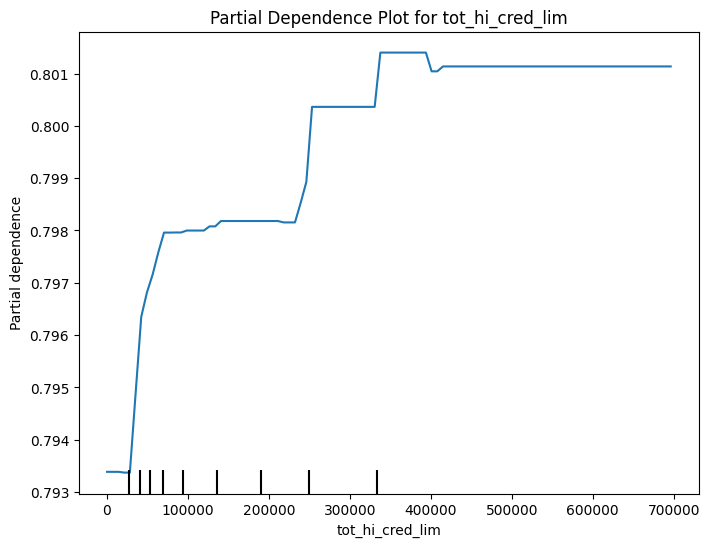

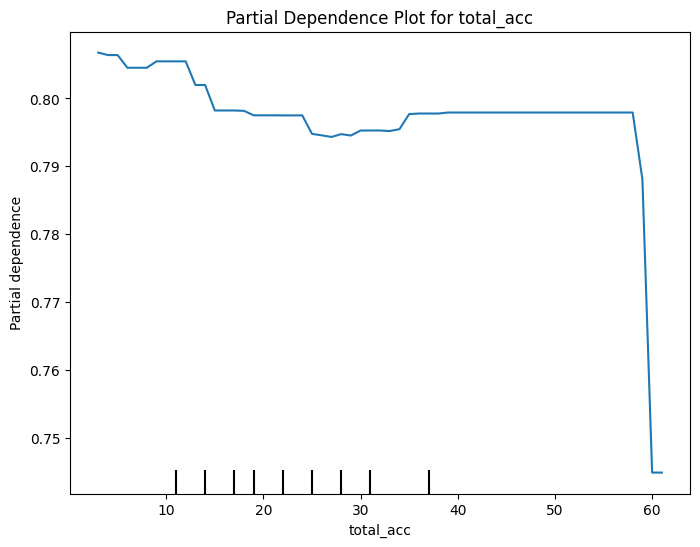

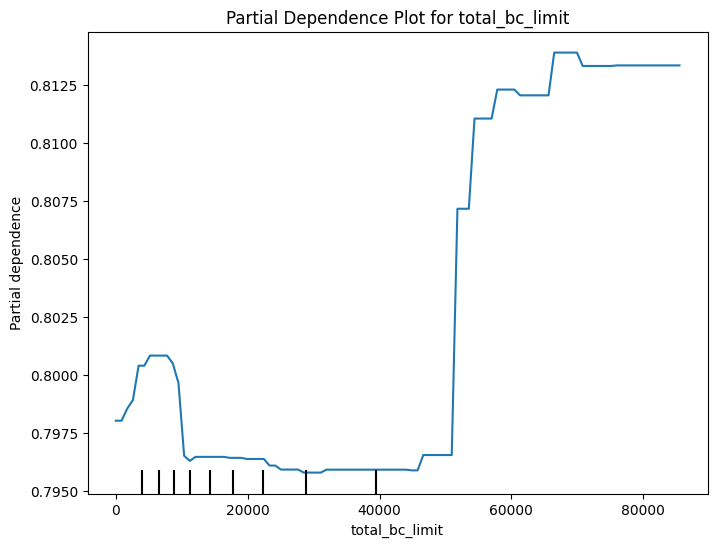

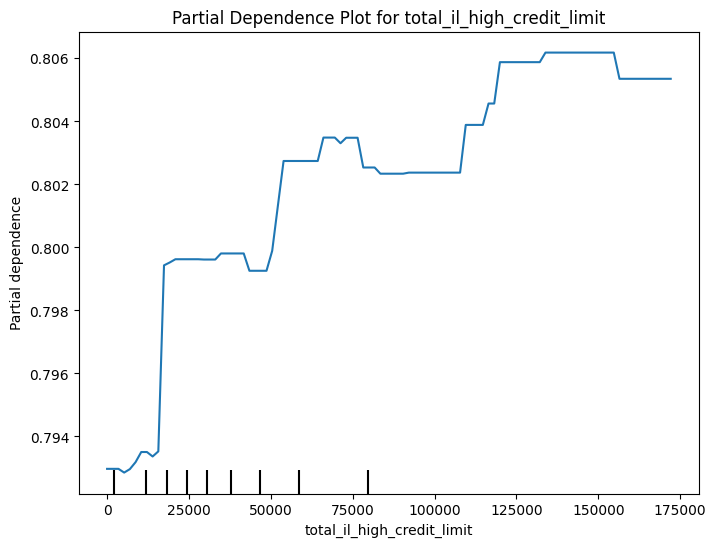

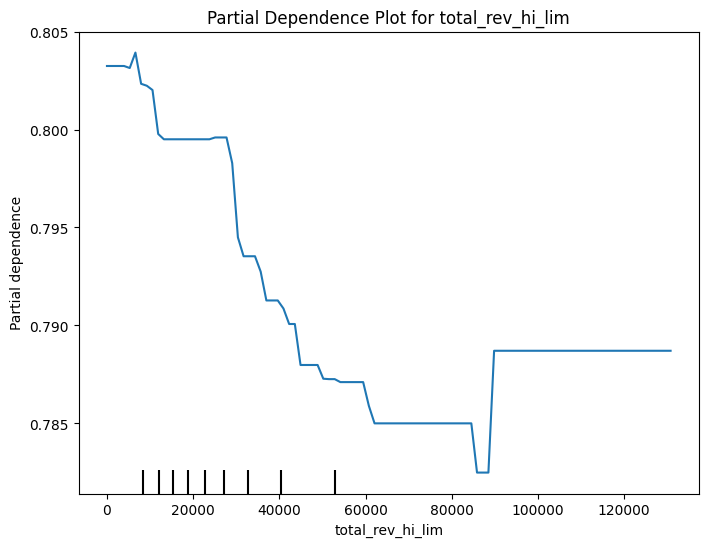

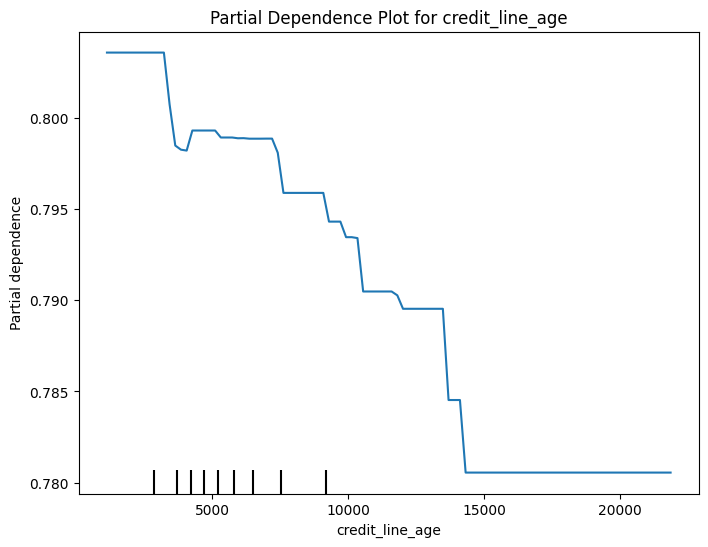

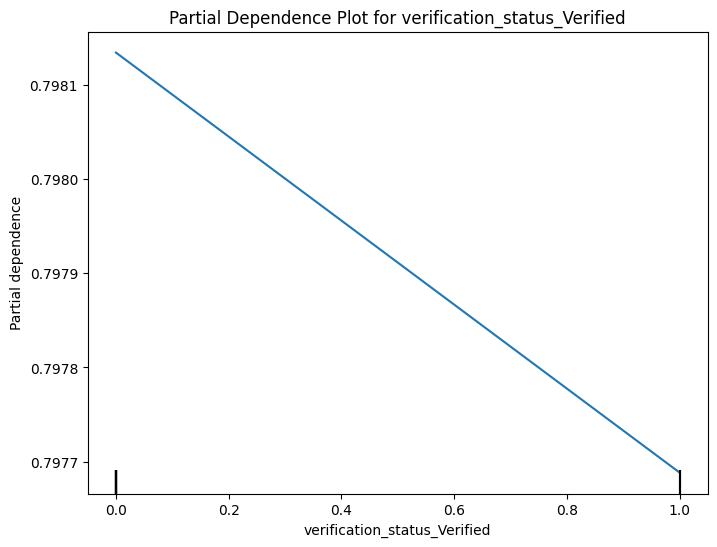

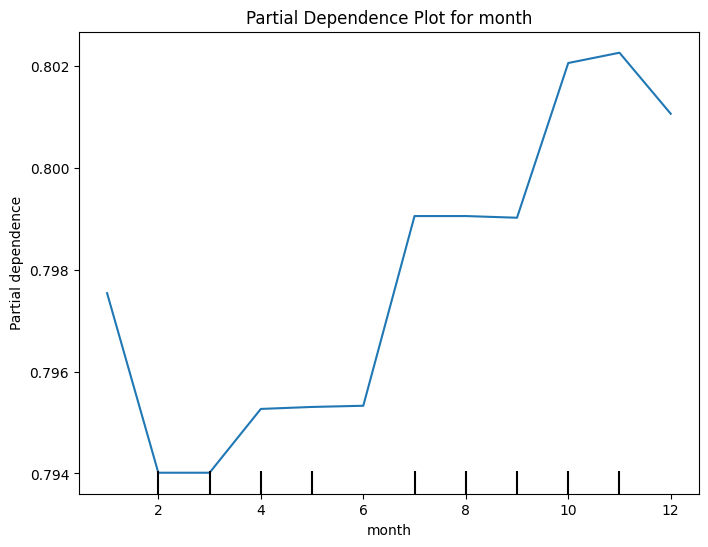

In [76]:
from sklearn.inspection import PartialDependenceDisplay
for feature in X.columns:
    plt.figure(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(
        estimator=final_model,
        X=X_train,
        features=[feature],
        kind="average",  # Change to 'both' to include ICE curves
        percentiles = (0,1),
        ax=plt.gca(),
    )
    plt.title(f"Partial Dependence Plot for {feature}")
    plt.show()